<strong><h1>PROJETO VIOLÊNCIA LETAL E INDICADORES SOCIOECONÔMICOS</h1></strong>

Script do trabalho de conclusão de curso: *"Fatores socioeconômicos da violência letal: evidências a partir de aprendizado de máquina"*

**Fonte:**

População utilizada no ano 1996: IBGE - Contagem Populacional; nos anos 1997-2003 e 2016:População Residente - Estimativas para o TCU - Brasil; 2004-2015: IBGE/Diretoria de Pesquisas. Coordenação de População e Indicadores Sociais. Gerência de Estudos e Análises da Dinâmica Demográfica. Somente na abrangência referente às Unidades Federativas.

IBGE - Contagem Populacional e População Residente - Estimativas para o TCU - Brasil. Para as outras abrangências referentes à Região e País.

MS/SVS/CGIAE - Sistema de Informações sobre Mortalidade - SIM

Para o período de 1979 a 1995 considera os códigos CIDs 9: E960-E978 (Homicídios e lesões provocadas intencionalmente outras pessoas) e E990-E999 (Intervenções legais).

A partir de 1996 considera os códigos CIDs 10: X85-Y09 (agressão) e Y35 (intervenção legal)

Óbitos por residência.

Taxa multiplicada por 100.000.

Elaboração Diest/Ipea.

**Comentário Crítico Sobre as Fontes**

O código X85-Y09 considera as mortes por agressão com arma de fogo, morte por agressão com causas não especificadas e por outros meios (força corporal, armas, explosivos etc.). Já o código Y35 consider as mortes por intervenção legal (i. e. Mortes por Intervenção de Agente do Estado). A soma deses indicadores configura o que o Fórum Brasileiro de Segurança Pública chama de "Mortes Violentas Intencionais" (MVI), ou seja, aquelas oriuntas de Crimes Violentos Letais e Intencionais (CVLI) e Mortes por Intervenção de Agente do Estado (MIAE). Esses dados foram disponibilizados pelo **DATASUS**

In [ ]:
# CARREGAR E SALVAR PARQUET
%pip install pyarrow 

# MANIPULAÇÃO DE DADOS
%pip install pandas
    # Não utilizar numpy 2.0, pois alguns métodos do sklearn utilizam a versão anterior e não irão funcionar
%pip install numpy==1.26.4 

# MODELOS ESTATÍSTICOS E MÉTRICAS
%pip install statsmodels
%pip install statstests
    # Ficar de olho na versão do sklearn, uma versão desatualizada pode dar conflito com o carregamento do modelo.
%pip install scikit-learn==1.5.1
%pip install scipy

# VISUALIZAÇÃO DE DADOS
%pip install seaborn
%pip install matplotlib
%pip install tqdm
%pip install tqdm_joblib
%pip install warnings


In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

<strong><h2>CARREGANDO A BASE DE DADOS</h2></strong>

A base de dados é composta por todos os municípios brasileiros e suas características socioeconômicas. 

In [23]:
df_unificado = pd.read_parquet(r"base_de_dados_completa.parquet")
df_unificado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5596 entries, 0 to 5595
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   COD                                   5596 non-null   int64  
 1   REGIAO                                5596 non-null   object 
 2   UF                                    5596 non-null   object 
 3   MUNICIPIO                             5596 non-null   object 
 4   POP_TOTAL_RESIDENTE                   5565 non-null   float32
 5   POP_RURAL_RESIDENTE                   5565 non-null   float32
 6   POP_URBANA_RESIDENTE                  5565 non-null   float32
 7   POP_HOMEM_RESIDENTE                   5565 non-null   float32
 8   POP_MULHER_RESIDENTE                  5565 non-null   float32
 9   POP_COR_BRANCA                        5565 non-null   float32
 10  POP_COR_NEGRA                         5564 non-null   float32
 11  IDHM_2010        

<strong><h3>Filtrando a base de dados</h3></strong>

Aqui a base de dados é filtrada para englobar apenas os municípios 100.000 habitantes ou mais. Conforme Cano e Santos (2016), as estatísticas e conclusões retiradas da análise podem variar bastante a depender do recorte espacial. Além disso, municípios muito pequenos são sujeitos a flutuações e inflações quanto à sua taxa de violência, por esta ser padronizada para 100.000 habitantes. Considerar apenas os municípios com 100.000 habitantes significa também que os municípios considerados serão majoritariamente urbanos, ou seja, restringindo a análise da violência à violência urbana.

In [3]:
df_unificado_filtrado = df_unificado[(df_unificado['POP_TOTAL_RESIDENTE'] >= 10**5)].dropna()
df_unificado_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283 entries, 11 to 5595
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   COD                                   283 non-null    int64  
 1   REGIAO                                283 non-null    object 
 2   UF                                    283 non-null    object 
 3   MUNICIPIO                             283 non-null    object 
 4   POP_TOTAL_RESIDENTE                   283 non-null    float32
 5   POP_RURAL_RESIDENTE                   283 non-null    float32
 6   POP_URBANA_RESIDENTE                  283 non-null    float32
 7   POP_HOMEM_RESIDENTE                   283 non-null    float32
 8   POP_MULHER_RESIDENTE                  283 non-null    float32
 9   POP_COR_BRANCA                        283 non-null    float32
 10  POP_COR_NEGRA                         283 non-null    float32
 11  IDHM_2010             

<strong><h3>Carregando a base de dados com taxas de violência de 2008 a 2022</h3></strong>

Essa base de dados foi criada pelo IPEA, com as taxas de violência municipal, Estadual e do Brasil desde os anos 90.

In [4]:
base_taxas_violencia_2010_2022 = pd.read_parquet('taxas_de_violencia_2008_2022.parquet')

<strong><h3>Filtrando a base de dados das taxas de violência</h3></strong>

Aqui a base de dados é filtrada para englobar apenas os municípios 100.000 habitantes ou mais. Conforme Cano e Santos (2016), as estatísticas e conclusões retiradas da análise podem variar bastante a depender do recorte espacial. Além disso, municípios muito pequenos são sujeitos a flutuações e inflações quanto à sua taxa de violência, por esta ser padronizada para 100.000 habitantes. Considerar apenas os municípios com 100.000 habitantes significa também que os municípios considerados serão majoritariamente urbanos, ou seja, restringindo a análise da violência à violência urbana.

In [5]:
base_taxas_de_violencia_2010_2022_filtrada = base_taxas_violencia_2010_2022[base_taxas_violencia_2010_2022['POP_TOTAL_RESIDENTE'] >= 10**5].dropna()
df_unificado_filtrado['TAXA_VIOLENCIA'] = base_taxas_de_violencia_2010_2022_filtrada[['TAXA_2010']].mean(axis=1).dropna()
df_unificado_filtrado = df_unificado_filtrado.dropna()

<strong><h3>Deletando as variaveis com as bases completas</h3></strong>

Como a análise é restrita aos municípios com 100.000 habitantes ou mais, não será necessário manter a base com todos os municípios. Caso se quiera analisar tudo, não rodar a célula seguinte.

In [6]:
del base_taxas_violencia_2010_2022, df_unificado, 

<strong><h2>ESTATISTICAS DESCRITIVAS</h2></strong>

Essa seção é dedicada às análises descritivas das taxas de violência entre municípios e unidades da federação

<strong><h3>Taxas anuais de Mortes Violentas: 2008 a 2022</h3></strong>

Ao observamos as estatísticas das taxas anuais de 2008 a 2022, percebemos que, provavelmente, há um problema com os dados de 2022, visto que há um município (Belém/PA) que tem uma taxa de mais de 7000 mortes por 100.000 habitantes. O boxplot mostra a distorção que esse ano causa em um plot conjunto das taxas anuais

In [10]:
base_taxas_de_violencia_2010_2022_filtrada.iloc[:,5:].describe().round(3)

TAXA_2008  TAXA_2009  TAXA_2010  TAXA_2011  TAXA_2012  TAXA_2013  \
count    282.000    282.000    282.000    282.000    282.000    282.000   
mean      31.457     31.539     31.608     31.499     33.587     32.831   
std       21.661     22.303     22.592     21.917     22.814     21.296   
min        0.860      0.760      0.000      2.500      0.690      1.370   
25%       14.010     14.665     14.620     14.100     16.093     15.492   
50%       27.645     26.500     25.305     26.635     27.690     28.475   
75%       43.132     41.498     42.820     42.408     44.958     45.973   
max      108.850    123.680    113.670    105.400    120.270    106.830   

       TAXA_2014  TAXA_2015  TAXA_2016  TAXA_2017  TAXA_2018  TAXA_2019  \
count    282.000    282.000    282.000    282.000    282.000    282.000   
mean      33.683     32.044     33.231     33.825     29.985     22.830   
std       22.180     21.030     23.225     25.016     22.676     15.834   
min        3.190      0.670      2.440      2.070      0.000      0.770   
25%       16.132     14.397     13.605     12.975     11.550      9.800   
50%       29.085     28.140     27.960     27.655     23.935     19.010   
75%       47.375     45.838     47.450     48.565     42.470     32.988   
max      121.280     95.730    118.260    137.200    110.940     71.630   

       TAXA_2020  TAXA_2021  TAXA_2022  
count    282.000    282.000    282.000  
mean      18.049     23.039     86.258  
std       20.890     17.181    486.628  
min        0.000      1.080      0.960  
25%        0.305      9.195      9.518  
50%        9.695     18.515     20.365  
75%       32.085     34.122     36.915  
max       97.790     78.410   7179.160

<Axes: >

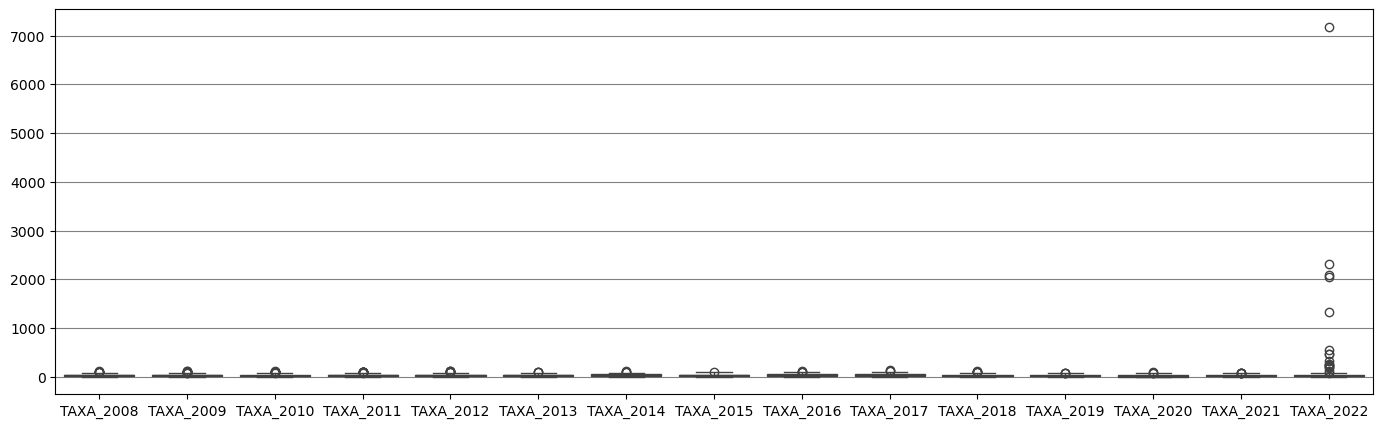

In [9]:
plt.figure(figsize=(17,5))
plt.grid('major', color='grey')
sns.boxplot(base_taxas_de_violencia_2010_2022_filtrada.iloc[:,5:])

Na célula seguinte, essas mesmas taxas de violência são exploradas de 2008 até 2021. Observa-se que a visualização melhorou significativamente e que o ano de 2022 não deve ser considerado na análise

<Axes: >

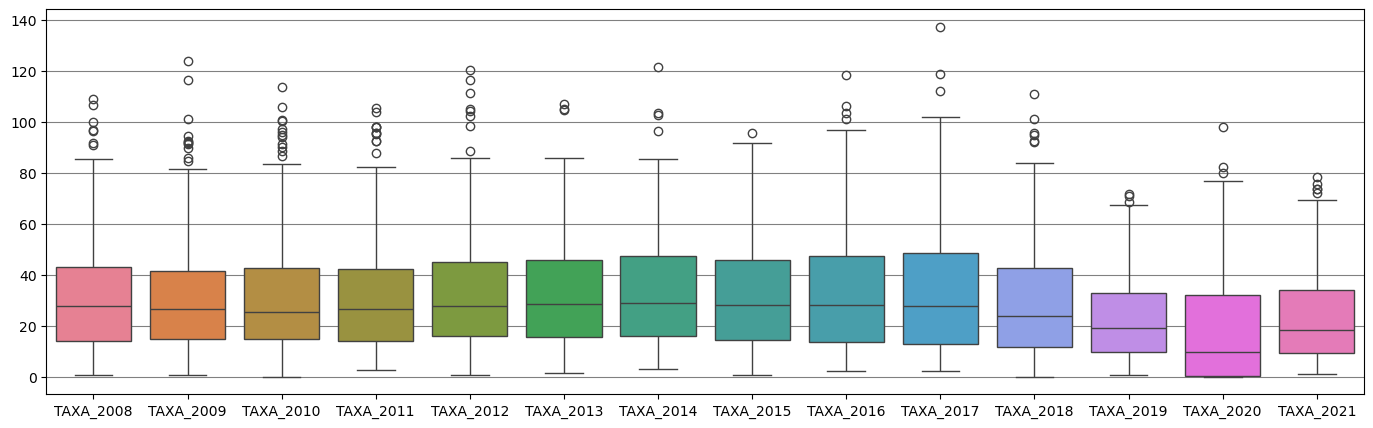

In [10]:
plt.figure(figsize=(17,5))
plt.grid('major', color='grey')
sns.boxplot(base_taxas_de_violencia_2010_2022_filtrada.iloc[:,5:-1])

<strong><h3>Analisando o ano de 2010</h3></strong>

Essa seção é dedicada à analise do ano de 2010 especificamente.

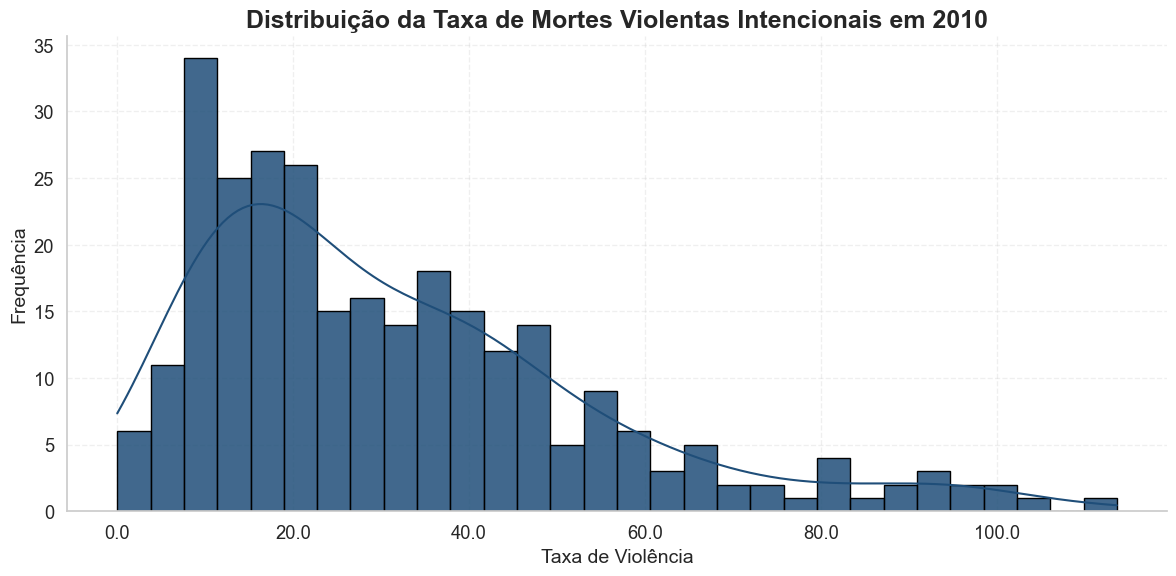

In [11]:
import matplotlib.ticker as mtick

# Estilo geral do seaborn
sns.set(style="whitegrid", context="notebook", font_scale=1.2)

# Tamanho da figura
plt.figure(figsize=(12, 6))

# Cor azul escuro
azul_escuro = "#1f4e79"

# Histograma com azul escuro
ax = sns.histplot(
    data=df_unificado_filtrado,
    x='TAXA_VIOLENCIA',
    bins=30,
    kde=True,
    color=azul_escuro,
    edgecolor='black',
    alpha=0.85
)

# Título e rótulos
plt.title("Distribuição da Taxa de Mortes Violentas Intencionais em 2010", fontsize=18, weight='bold')
plt.xlabel("Taxa de Violência", fontsize=14)
plt.ylabel("Frequência", fontsize=14)

# Formatadores bonitos
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}'))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{int(y):,}'))

# Limpar bordas superiores/direita
sns.despine()

# Grid leve
ax.grid(True, which='major', linestyle='--', alpha=0.3)

# Layout final
plt.tight_layout()
plt.show()


In [12]:
def plot_box_uf(
    titulo:str, 
    y_label:str, 
    df:pd.DataFrame, 
    x:str, 
    y:pd.Series, 
    hue:pd.Series='UF'
):

    """Função para gerar um modelo padrão de boxplots para explorar as variáveis independentes. Por padrão, retorna um boxplot da variável independente de escolha (y) segundo unidade federativa (x)."""
    plt.figure(figsize=(15,5))
    plt.grid(which='major', color='grey')
    plt.ylabel(y_label)
    plt.xlabel("")
    plt.title(titulo, fontsize=15)
    sns.boxplot(df_unificado_filtrado, 
                x=x,
                y=y,
                hue=hue,
                palette='viridis')
    plt.show()

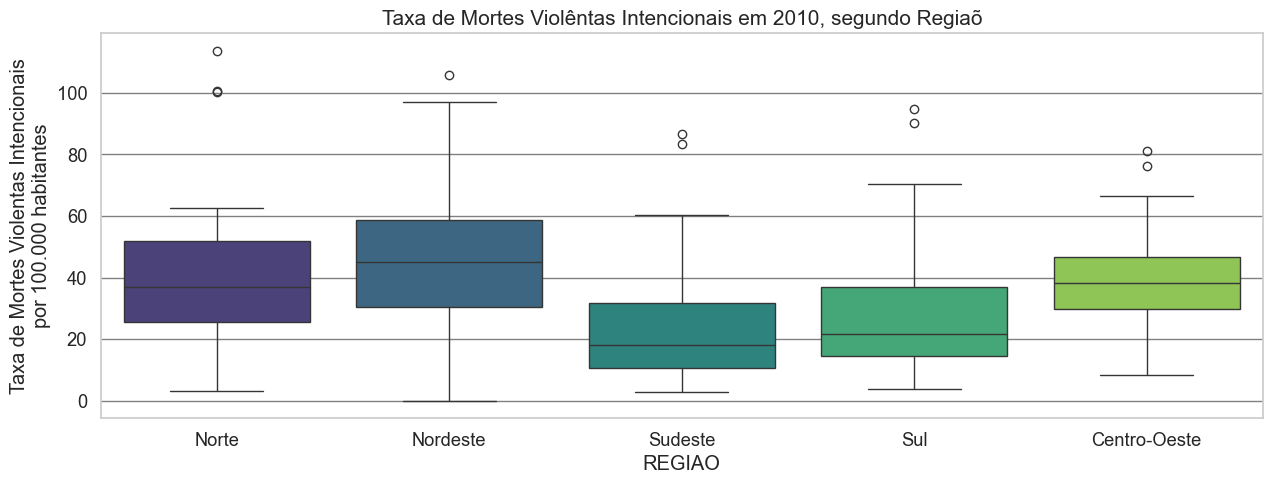

In [13]:
plot_box_uf('Taxa de Mortes Violêntas Intencionais em 2010, segundo Regiaõ', 
            'Taxa de Mortes Violentas Intencionais\npor 100.000 habitantes', 
            df=df_unificado_filtrado,
            x='REGIAO',
            y='TAXA_VIOLENCIA',
            hue='REGIAO')

Esta análise exploratória da variável alvo — a taxa de mortes violentas — revela uma heterogeneidade fundamental que justifica a abordagem de modelagem. A vasta disparidade entre as medianas e as distribuições das taxas de violência entre os estados (UFs) confirma que a localização geográfica, representada pela UF, é uma feature categórica de alta importância preditiva. Estados como Pará (PA) e Bahia (BA) exibem uma dispersão imensa (grande intervalo interquartil), indicando que a violência não é um fenômeno homogêneo nem mesmo dentro de um mesmo estado, o que reforça a necessidade de um modelo que opere no nível municipal. A presença de múltiplos outliers em diversas UFs valida a escolha do Random Forest, um algoritmo robusto que não é indevidamente influenciado por esses valores extremos e é capaz de capturar as complexas interações entre a localização e os determinantes da violência

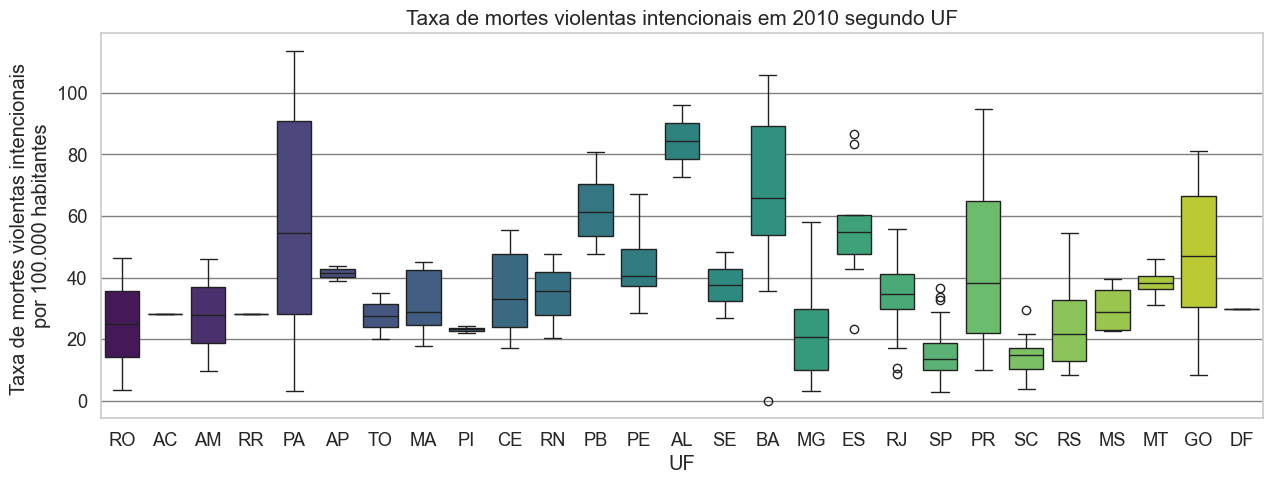

count    282.000000
mean      31.608333
std       22.591941
min        0.000000
25%       14.620000
50%       25.305000
75%       42.820000
max      113.670000
Name: TAXA_VIOLENCIA, dtype: float64

In [14]:
plot_box_uf(titulo='Taxa de mortes violentas intencionais em 2010 segundo UF',
            y_label='Taxa de mortes violentas intencionais \npor 100.000 habitantes',
            df=df_unificado_filtrado,
            x='UF',
            y='TAXA_VIOLENCIA')
df_unificado_filtrado['TAXA_VIOLENCIA'].describe()

A comparação entre o Índice de Desenvolvimento Humano Municipal (IDHM) e as taxas de mortes violentas de 2010 por estado revela uma forte, porém não absoluta, correlação inversa. Estados com baixo IDHM, como Alagoas, tenderam a ter as maiores taxas de violência, enquanto aqueles com alto IDHM, como São Paulo e Santa Catarina, apresentaram os menores índices. No entanto, essa relação é complexificada por exceções importantes, como Piauí, que possuía baixo desenvolvimento mas violência contida, e Espírito Santo, que, apesar do bom IDHM, enfrentava altas taxas de violência. A variabilidade do IDHM dentro de estados como Pará (PA) e Maranhão (MA) também é um dado crucial, pois sinaliza que o modelo de Random Forest precisará aprender a diferenciar os desfechos de segurança com base na grande desigualdade de desenvolvimento que existe entre os municípios de um mesmo estado, indo além das médias estaduais.

As considerações acima, sobre a relação entre taxa de violência e IDH (que é composto por indicadores de saude, educação e renda), são reforçadas pela correlação inversa moderada de -0.448, indicando que há, sim, uma relação entre taxa de violência e indicadores socioeconômicos nos municipios considerados 

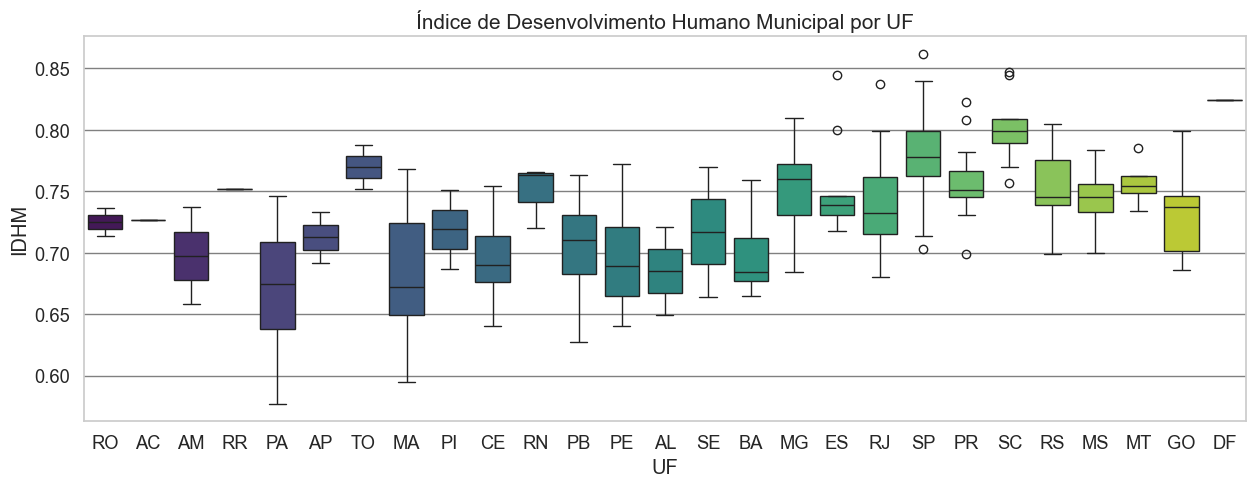

                TAXA_VIOLENCIA  IDHM_2010
TAXA_VIOLENCIA        1.000000  -0.446835
IDHM_2010            -0.446835   1.000000


In [15]:
plot_box_uf(titulo='Índice de Desenvolvimento Humano Municipal por UF',
            y_label="IDHM",
            df=df_unificado_filtrado,
            x='UF',
            y='IDHM_2010',
            hue='UF')
print(df_unificado_filtrado[['TAXA_VIOLENCIA','IDHM_2010']].corr())

Com base nos gráficos, a análise conjunta dos índices de Gini e Theil oferece uma camada de explicação fundamental para o modelo de regressão, focada na desigualdade de renda. Ambos os indicadores, apesar de terem escalas e sensibilidades distintas, apresentam uma distribuição geográfica muito semelhante, com os maiores níveis de desigualdade concentrados em municípios dos estados do Norte e Nordeste (como Maranhão, Piauí e Alagoas) e os menores no Sul (notadamente Santa Catarina). Este padrão espelha de forma consistente a distribuição da violência letal, validando a hipótese de que a desigualdade, e não apenas a pobreza absoluta, é um preditor chave. Para o projeto, a alta correlação entre Gini e Theil indica colinearidade, o que exigirá uma decisão na etapa de engenharia de features: pode-se optar por um dos dois (geralmente o Gini por ser mais difundido) ou utilizar técnicas de redução de dimensionalidade. A inclusão de uma variável de desigualdade é crucial, pois permitirá ao modelo de Random Forest testar hipóteses de "privação relativa" e capturar as tensões sociais que podem impulsionar a violência em locais onde a riqueza é mal distribuída, um fator que o IDHM ou os dados de saneamento por si sós não capturam completamente.

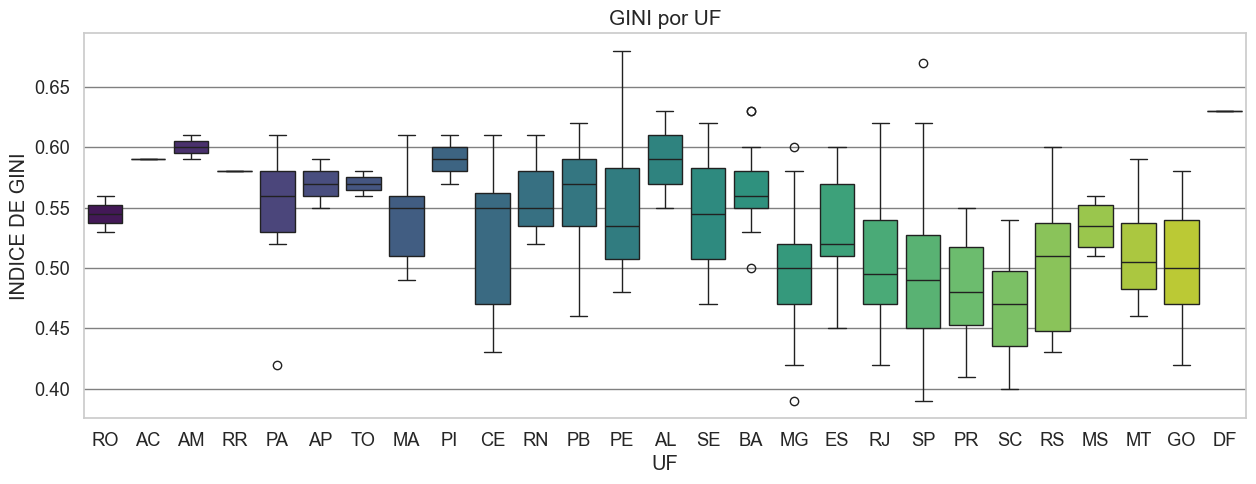

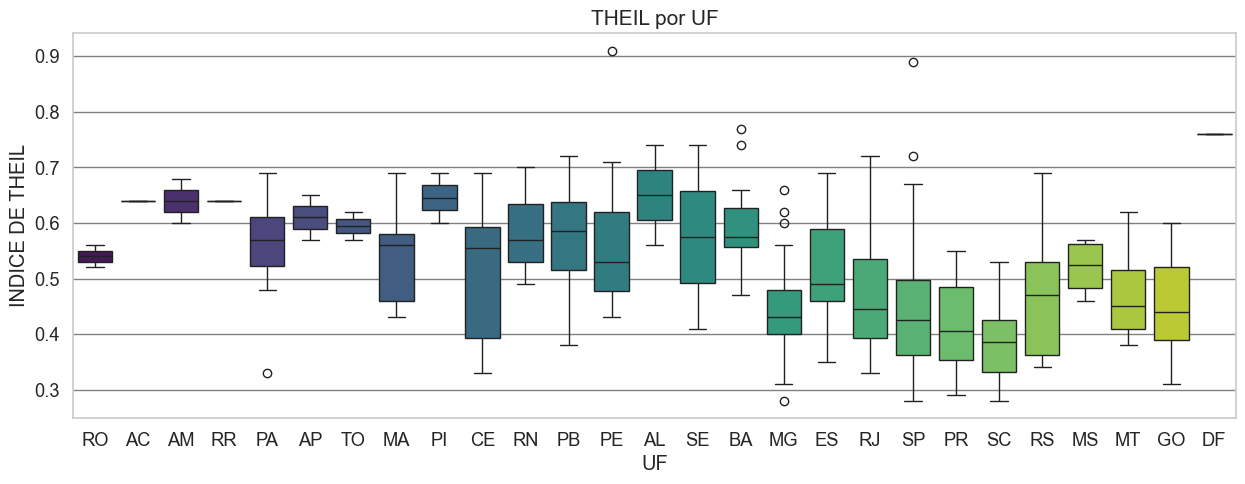

                TAXA_VIOLENCIA  GINI_2010  THEIL_2010
TAXA_VIOLENCIA        1.000000   0.132261    0.162997
GINI_2010             0.132261   1.000000    0.987736
THEIL_2010            0.162997   0.987736    1.000000


In [18]:
plot_box_uf(titulo='GINI por UF',
            y_label="INDICE DE GINI",
            df=df_unificado_filtrado,
            x='UF',
            y='GINI_2010',
            hue='UF')

plot_box_uf(titulo='THEIL por UF',
            y_label="INDICE DE THEIL",
            df=df_unificado_filtrado,
            x='UF',
            y='THEIL_2010',
            hue='UF')

print(df_unificado_filtrado[['TAXA_VIOLENCIA','GINI_2010',"THEIL_2010"]].corr())

Este gráfico, que mede o percentual de residências com saneamento e água inadequados, introduz uma feature de infraestrutura básica extremamente relevante para o modelo de regressão. A hipótese de trabalho aqui é de uma correlação positiva: quanto maior o déficit de saneamento, maior a taxa de violência letal, ainda que essa correlação seja fraca. A análise visual sustenta fortemente essa hipótese. Estados das regiões Norte e Nordeste, como Pará (PA), Amapá (AP), Acre (AC) e Maranhão (MA), que apresentam os maiores percentuais de inadequação, também estão entre os que registraram taxas de violência mais altas ou mais dispersas. Em contrapartida, estados do Sudeste e Sul, como São Paulo (SP), Paraná (PR) e Santa Catarina (SC), que possuem os melhores indicadores de saneamento (valores próximos de zero no gráfico), são exatamente aqueles com os menores índices de violência. Para o modelo de Random Forest, essa variável é potencialmente muito poderosa, pois funciona como um proxy direto para a precariedade das condições de vida e a ausência de serviços estatais básicos.

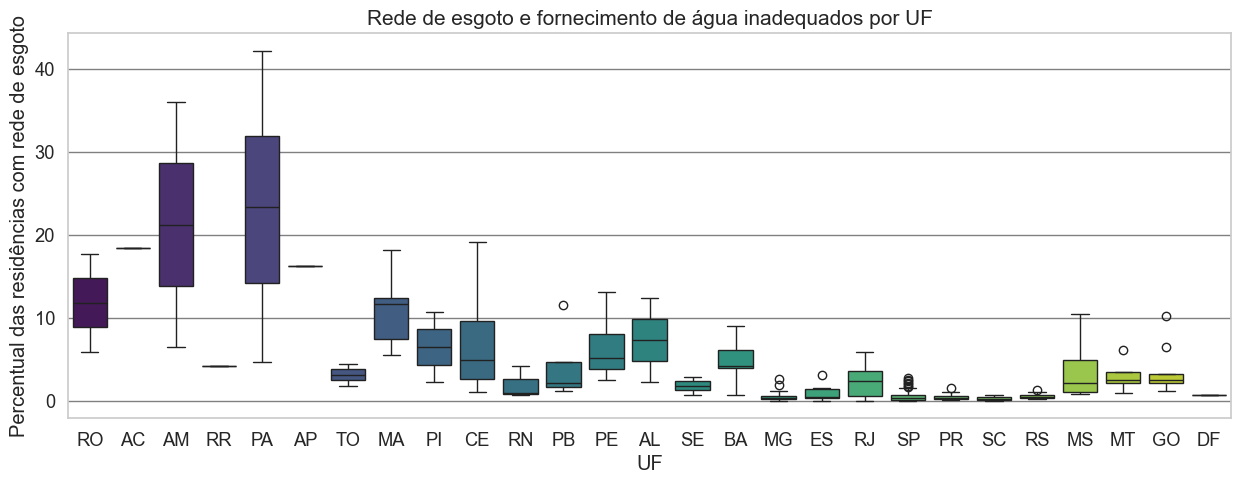

                              TAXA_VIOLENCIA  AGUA-ESGOTAMENTO_INADEQUADOS
TAXA_VIOLENCIA                      1.000000                      0.203497
AGUA-ESGOTAMENTO_INADEQUADOS        0.203497                      1.000000


In [19]:
plot_box_uf(titulo='Rede de esgoto e fornecimento de água inadequados por UF',
            y_label="Percentual das residências com rede de esgoto",
            df=df_unificado_filtrado,
            x='UF',
            y='AGUA-ESGOTAMENTO_INADEQUADOS',
            hue='UF')
print(df_unificado_filtrado[['TAXA_VIOLENCIA',"AGUA-ESGOTAMENTO_INADEQUADOS"]].corr())

A análise deste indicador revela-se crucial para o projeto, com a apuração de uma correlação positiva e moderada de 0.405 entre a proporção de vulneráveis à pobreza e a taxa de violência letal. Este coeficiente quantifica e valida estatisticamente o que a análise visual do gráfico já indicava: uma clivagem socioeconômica nítida, com os maiores percentuais de pobreza concentrados nos municípios do Norte e Nordeste (destacando-se Maranhão e Alagoas), em contraste com os baixos índices do Sul (notadamente Santa Catarina). Com essa validação numérica, esta variável se firma como uma feature de alto impacto para o modelo de Random Forest. Embora sua provável colinearidade com outros indicadores (como baixo IDHM) deva ser considerada na etapa de engenharia de features, a sua inclusão é agora fundamental para que o modelo possa mensurar o efeito da pobreza absoluta, uma dimensão de vulnerabilidade social cujo poder preditivo foi confirmado por uma métrica estatística concreta.

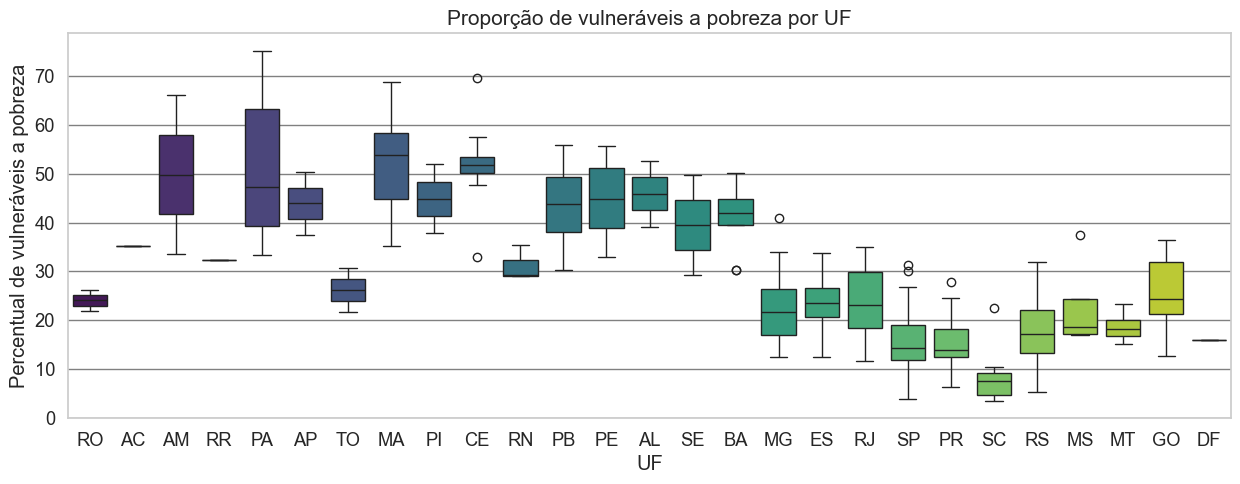

                          TAXA_VIOLENCIA  PROP_VULNERAVEIS_POBREZA
TAXA_VIOLENCIA                  1.000000                  0.404056
PROP_VULNERAVEIS_POBREZA        0.404056                  1.000000


In [20]:
plot_box_uf(titulo='Proporção de vulneráveis a pobreza por UF',
            y_label="Percentual de vulneráveis a pobreza",
            df=df_unificado_filtrado,
            x='UF',
            y='PROP_VULNERAVEIS_POBREZA',
            hue='UF')
print(df_unificado_filtrado[['TAXA_VIOLENCIA',"PROP_VULNERAVEIS_POBREZA"]].corr())

A inclusão do indicador de analfabetismo na população de 15 anos ou mais introduz uma feature educacional fundamental ao modelo. A correlação apurada, de 0.311, confirma uma relação positiva e estatisticamente relevante com a violência letal, embora de magnitude mais moderada em comparação com a pobreza. Este dado quantitativo é corroborado pela análise visual do gráfico, que (apesar do erro no rótulo do eixo Y) demonstra um padrão geográfico já familiar: as maiores taxas de analfabetismo estão concentradas nos municípios do Nordeste (com destaque para Alagoas e Piauí), enquanto as menores se encontram no Sul e Sudeste (notadamente Santa Catarina e São Paulo). Para o projeto, a inclusão desta variável é justificada pois permite ao modelo de Random Forest isolar e medir o impacto específico do déficit educacional, distinguindo-o de fatores puramente econômicos ou de infraestrutura, e enriquecendo a compreensão multifacetada dos determinantes da violência.

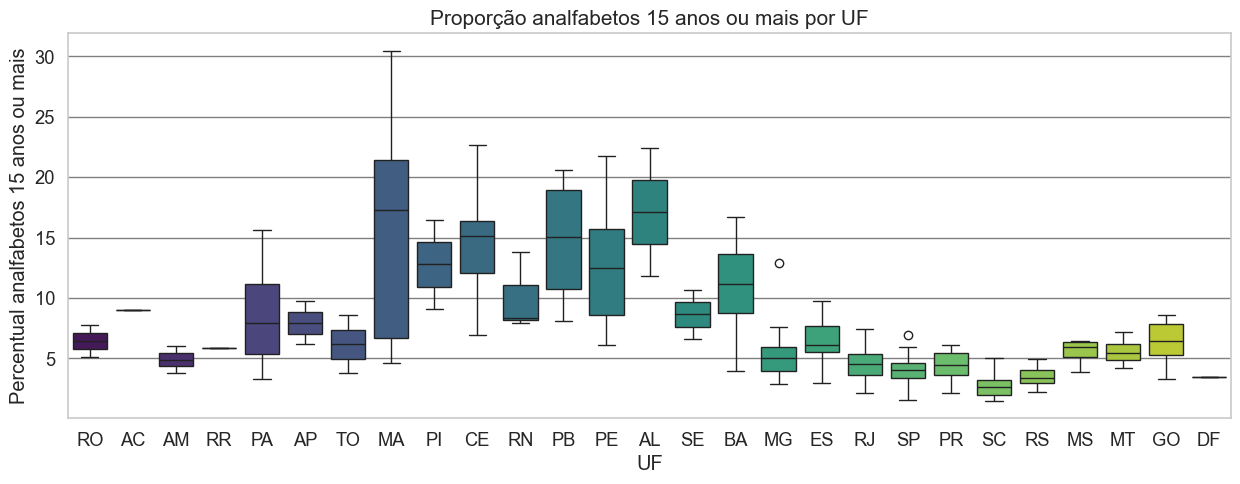

                       TAXA_VIOLENCIA  ANALFABETISMO_15_ANOS
TAXA_VIOLENCIA               1.000000               0.309629
ANALFABETISMO_15_ANOS        0.309629               1.000000


In [21]:
plot_box_uf(titulo='Proporção analfabetos 15 anos ou mais por UF',
            y_label="Percentual analfabetos 15 anos ou mais",
            df=df_unificado_filtrado,
            x='UF',
            y='ANALFABETISMO_15_ANOS',
            hue='UF')
print(df_unificado_filtrado[['TAXA_VIOLENCIA',"ANALFABETISMO_15_ANOS"]].corr())

<strong><h2>DIAGNÓSTICO DE MULTICOLINEARIDADE</h2></strong>

A maioria dos indicadores socioeconômicos considerados aqui são correlacionados com a taxa de violência, mas também são correlacionados entre si. Esse fato indica um possível desafio ao objetivo de construir um modelo de regressão, cujo pressuposto de independência das variáveis preditoras não pode ser garantido.

In [22]:
df_unificado_filtrado.loc[:,'POP_TOTAL_RESIDENTE':].corr().round(3)

POP_TOTAL_RESIDENTE  \
POP_TOTAL_RESIDENTE                                 1.000   
POP_RURAL_RESIDENTE                                 0.263   
POP_URBANA_RESIDENTE                                1.000   
POP_HOMEM_RESIDENTE                                 1.000   
POP_MULHER_RESIDENTE                                1.000   
POP_COR_BRANCA                                      0.973   
POP_COR_NEGRA                                       0.955   
IDHM_2010                                           0.195   
GINI_2010                                           0.308   
THEIL_2010                                          0.332   
ESPERANCA_VIDA_NASCER                               0.060   
ANALFABETISMO_15_ANOS                              -0.132   
ENS_FUND_25_ANOS_OU_MAIS                            0.276   
ENS_MEDIO_25_ANOS_OU_MAIS                           0.277   
ENS_SUPERIOR_25_ANOS_OU_MAIS                        0.276   
POP_AGUA_ENCANADA                                   0.084   
AGUA-ESGOTAMENTO_INADEQUADOS                       -0.076   
COLETA_LIXO                                         0.072   
REDE_ESGOTO                                         0.132   
ENERGIA_ELETRICA                                    0.061   
RENDA_PERCAPITA                                     0.303   
RENDA_PERCAPITA_5_MAIS_POBRE                        0.051   
RENDA_PERCAPITA_2°_QUINTO_MAIS_POBRE                0.090   
RENDA_PERCAPITA_3°_QUINTO_MAIS_POBRE                0.139   
RENDA_PERCAPITA_4°_QUINTO_MAIS_POBRE                0.219   
PROP_EXTREM_POBRES                                 -0.078   
PROP_POBRES                                        -0.081   
PROP_VULNERAVEIS_POBREZA                           -0.087   
RENDA_TOP_10_PORCENTO_MAIOR_RENDA                   0.309   
RENDA_40_PORCENTO_MAIS_POBRE                       -0.289   
HOMICIDIOS_DATASUS                                  0.821   
HOMICIDIOS_FEMININO                                 0.879   
HOMICIDIOS_MASCULINO                                0.813   
HOMICIDIOS_15_29_ANOS_DATASUS                       0.736   
HOMICIDIOS_MASCULINO_15_29_ANOS                     0.726   
POP_ECON_ATIVA                                      0.999   
FORMAL_TRAB                                         0.076   
POP_OCUP_FUND_COMPLETO                              0.234   
POP_OCUP_MEDIO_COMPLETO                             0.246   
TAXA_DESOCUP_18_MAIS                                0.015   
TAXA_VIOLENCIA                                      0.015   

                                      POP_RURAL_RESIDENTE  \
POP_TOTAL_RESIDENTE                                 0.263   
POP_RURAL_RESIDENTE                                 1.000   
POP_URBANA_RESIDENTE                                0.244   
POP_HOMEM_RESIDENTE                                 0.265   
POP_MULHER_RESIDENTE                                0.261   
POP_COR_BRANCA                                      0.248   
POP_COR_NEGRA                                       0.256   
IDHM_2010                                          -0.319   
GINI_2010                                           0.338   
THEIL_2010                                          0.330   
ESPERANCA_VIDA_NASCER                              -0.364   
ANALFABETISMO_15_ANOS                               0.347   
ENS_FUND_25_ANOS_OU_MAIS                           -0.223   
ENS_MEDIO_25_ANOS_OU_MAIS                          -0.144   
ENS_SUPERIOR_25_ANOS_OU_MAIS                       -0.102   
POP_AGUA_ENCANADA                                  -0.567   
AGUA-ESGOTAMENTO_INADEQUADOS                        0.518   
COLETA_LIXO                                        -0.405   
REDE_ESGOTO                                        -0.332   
ENERGIA_ELETRICA                                   -0.415   
RENDA_PERCAPITA                                    -0.193   
RENDA_PERCAPITA_5_MAIS_POBRE                       -0.358   
RENDA_PERCAPITA_2°_QUINTO_MAIS_POBRE               -0.340   
RENDA_PERCA

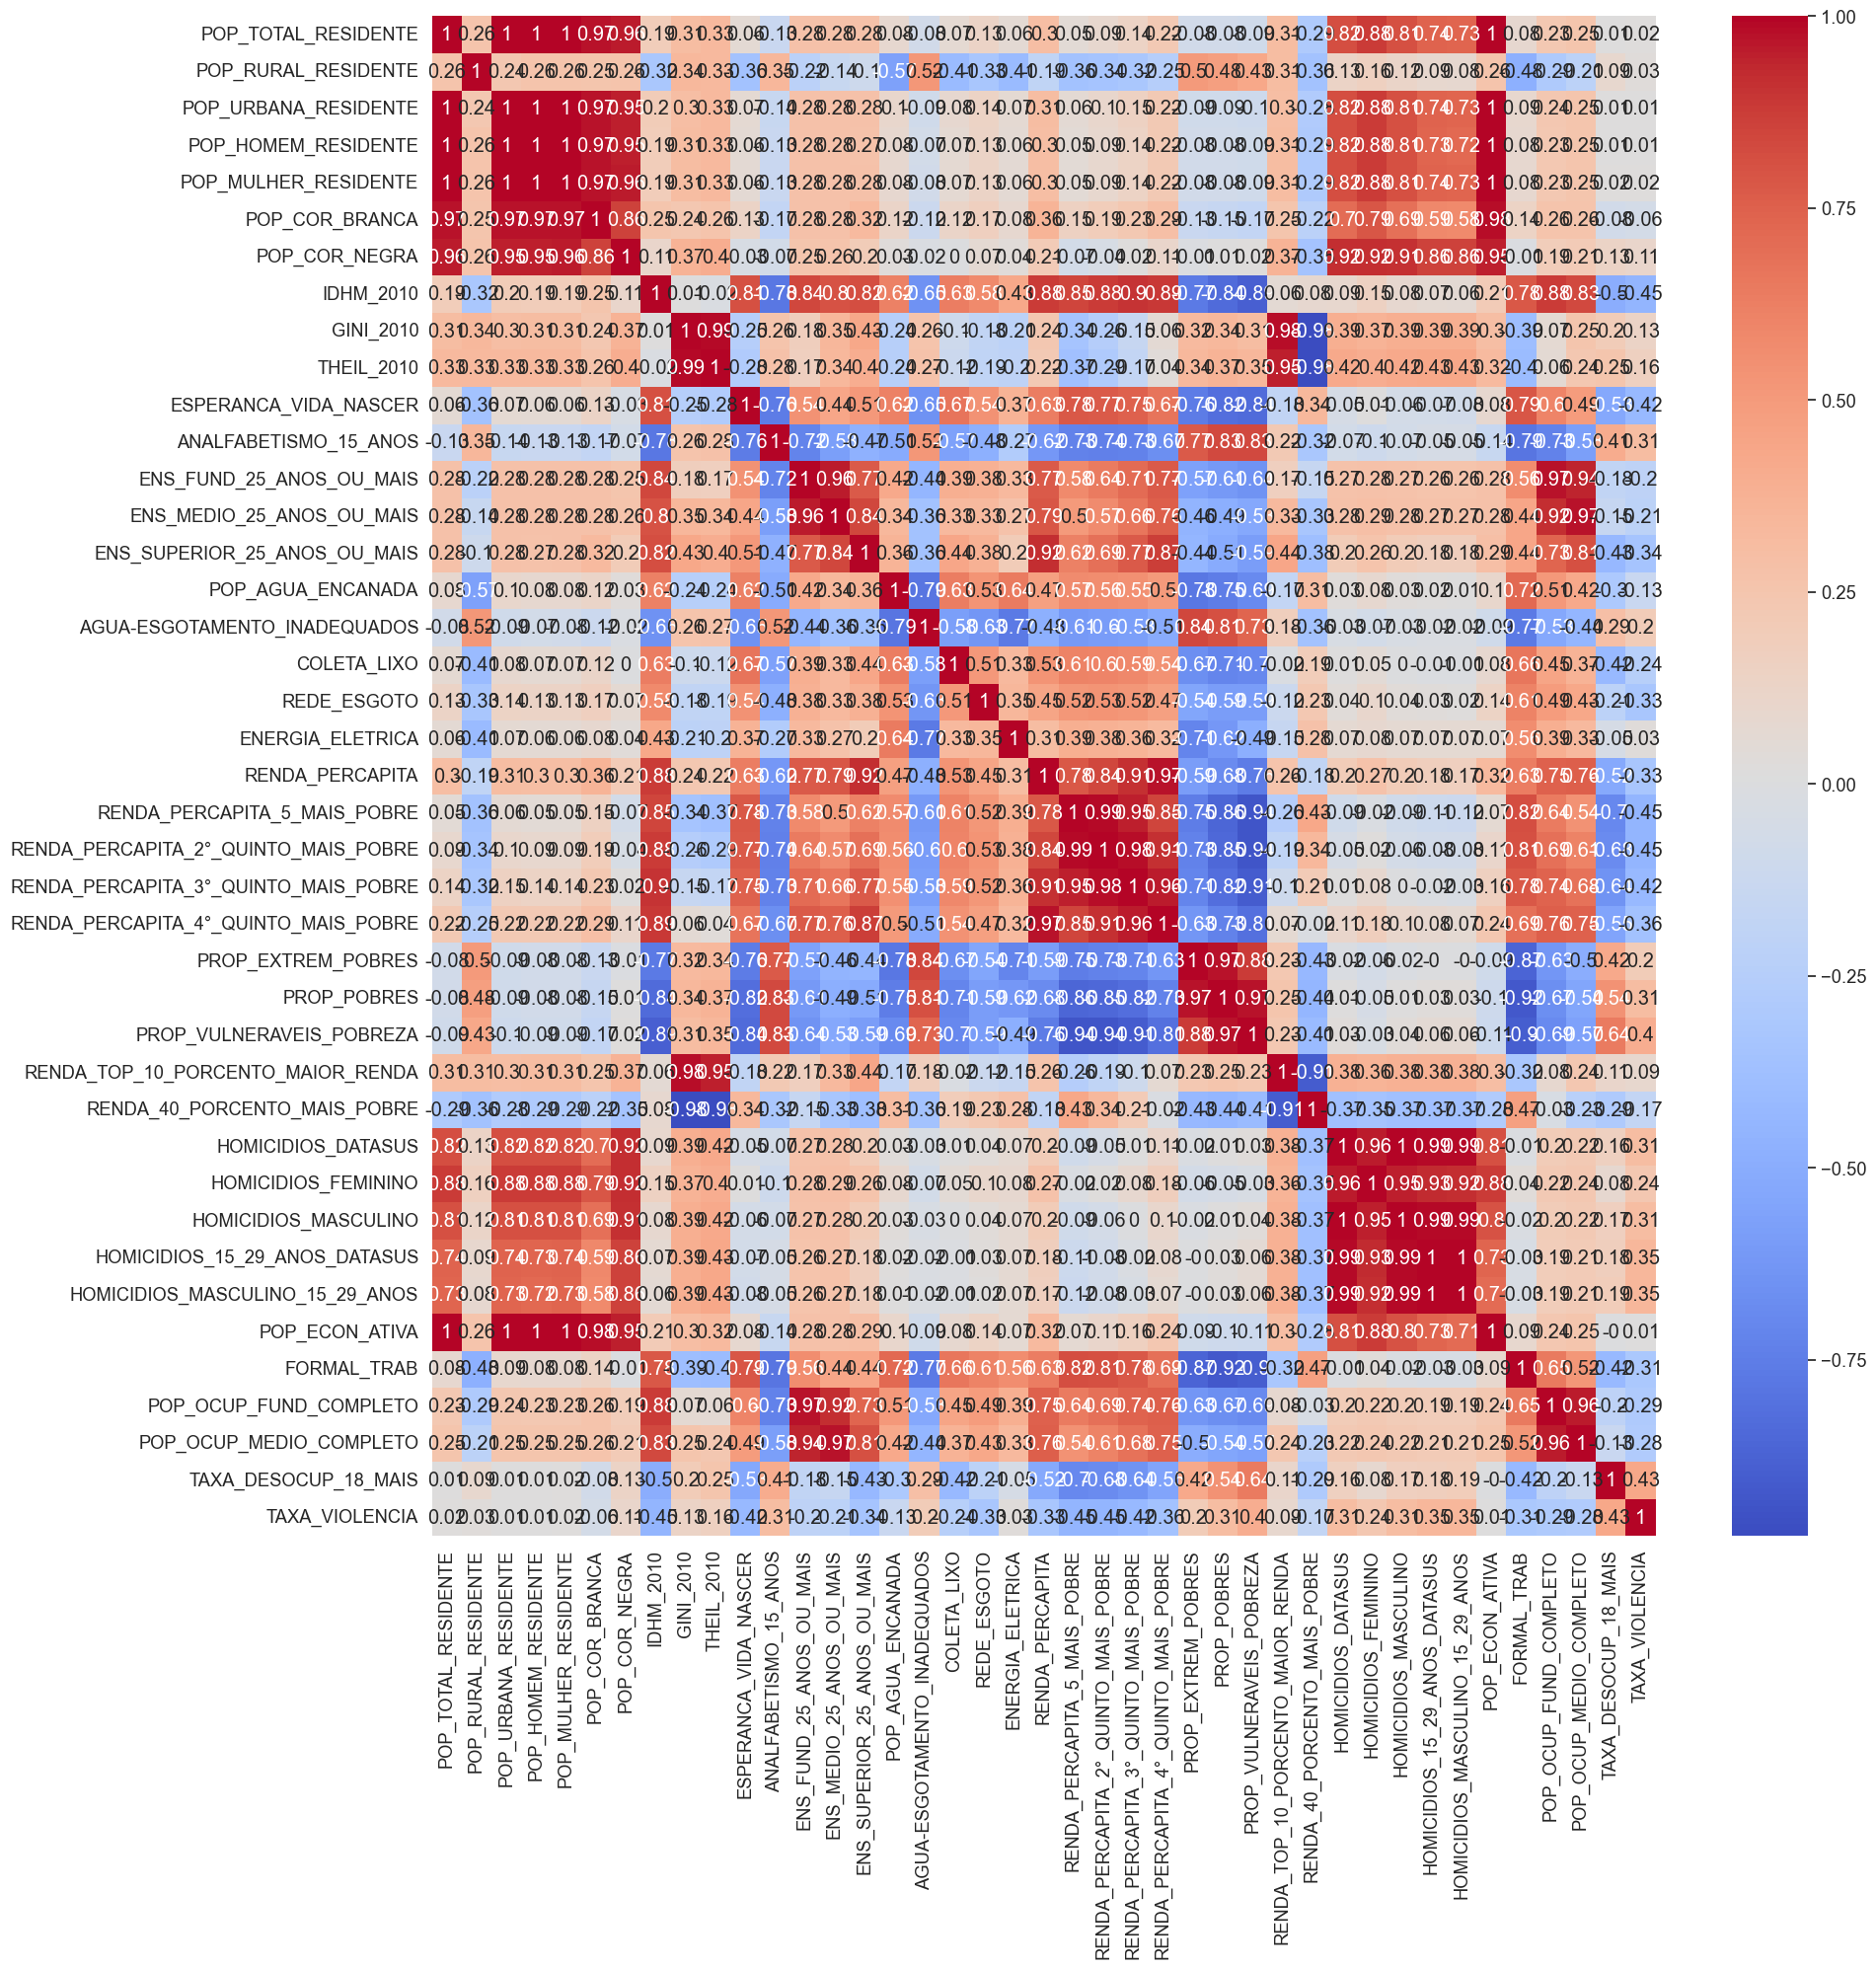

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(df_unificado_filtrado.iloc[:,4:].corr().round(2),
            annot=True, 
            cmap='coolwarm')
plt.show()

<strong><h3>Diagnóstico por Variance Inflation Factor (VIF)</h3></strong>


In [7]:
X = df_unificado_filtrado.loc[:, "POP_TOTAL_RESIDENTE": "TAXA_DESOCUP_18_MAIS"].drop(columns=['POP_RURAL_RESIDENTE', 'POP_HOMEM_RESIDENTE',
       'POP_MULHER_RESIDENTE', 'POP_COR_BRANCA', 'POP_COR_NEGRA','HOMICIDIOS_DATASUS', 'HOMICIDIOS_FEMININO', 'HOMICIDIOS_MASCULINO',
       'HOMICIDIOS_15_29_ANOS_DATASUS', 'HOMICIDIOS_MASCULINO_15_29_ANOS']).dropna()

y = df_unificado_filtrado['TAXA_VIOLENCIA'].dropna()

In [8]:
df_unificado_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 282 entries, 11 to 5595
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   COD                                   282 non-null    int64  
 1   REGIAO                                282 non-null    object 
 2   UF                                    282 non-null    object 
 3   MUNICIPIO                             282 non-null    object 
 4   POP_TOTAL_RESIDENTE                   282 non-null    float32
 5   POP_RURAL_RESIDENTE                   282 non-null    float32
 6   POP_URBANA_RESIDENTE                  282 non-null    float32
 7   POP_HOMEM_RESIDENTE                   282 non-null    float32
 8   POP_MULHER_RESIDENTE                  282 non-null    float32
 9   POP_COR_BRANCA                        282 non-null    float32
 10  POP_COR_NEGRA                         282 non-null    float32
 11  IDHM_2010             

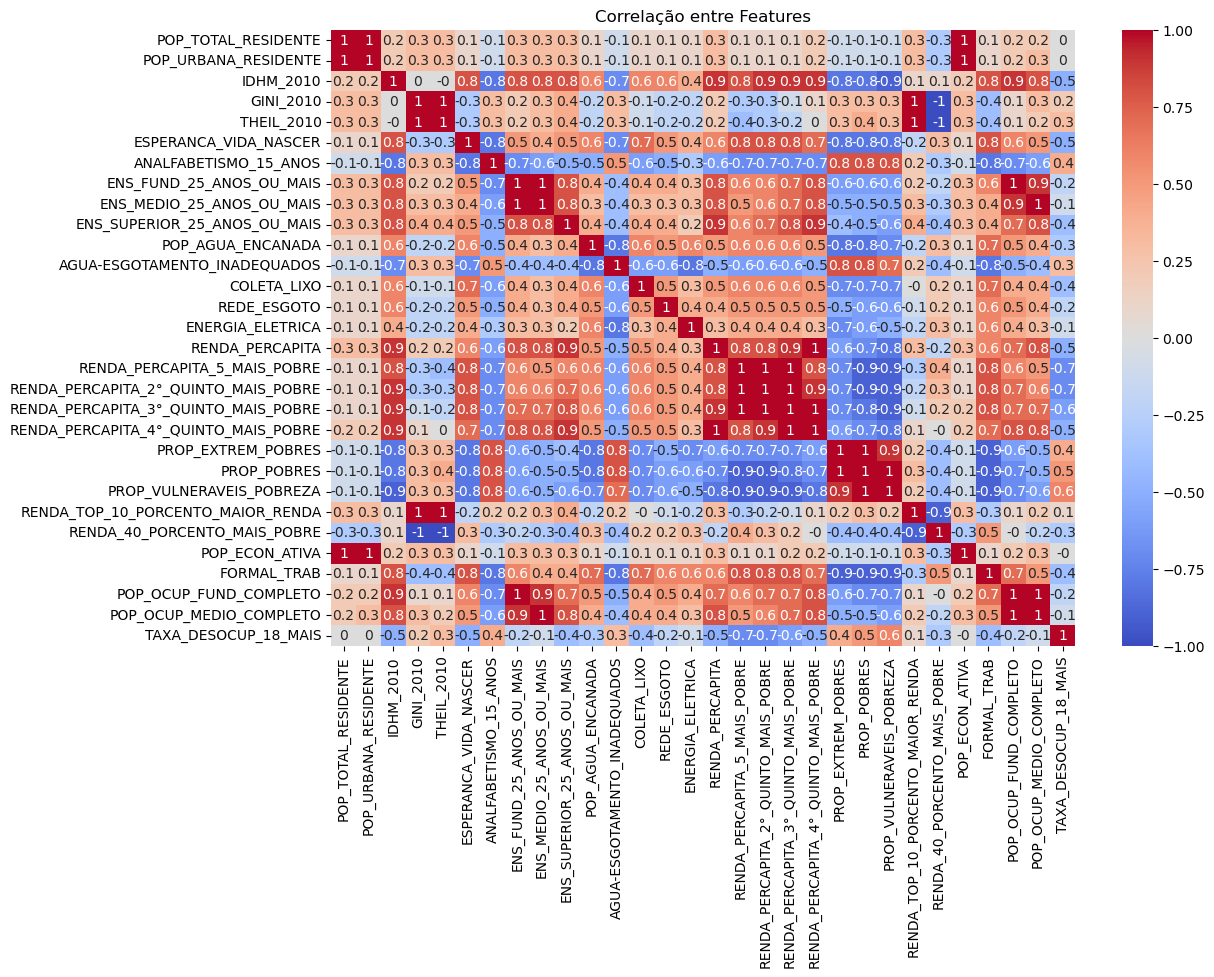

                                 feature           VIF
3                              GINI_2010  19618.487664
27                POP_OCUP_FUND_COMPLETO  18167.717234
14                      ENERGIA_ELETRICA  14382.751270
7               ENS_FUND_25_ANOS_OU_MAIS  14102.402390
5                  ESPERANCA_VIDA_NASCER  12412.578079
2                              IDHM_2010  11985.796015
28               POP_OCUP_MEDIO_COMPLETO  10203.336546
8              ENS_MEDIO_25_ANOS_OU_MAIS   9094.194610
0                    POP_TOTAL_RESIDENTE   9024.213591
23     RENDA_TOP_10_PORCENTO_MAIOR_RENDA   8250.035699
1                   POP_URBANA_RESIDENTE   6848.196075
17  RENDA_PERCAPITA_2°_QUINTO_MAIS_POBRE   6537.423777
18  RENDA_PERCAPITA_3°_QUINTO_MAIS_POBRE   6474.617857
19  RENDA_PERCAPITA_4°_QUINTO_MAIS_POBRE   4517.877390
24          RENDA_40_PORCENTO_MAIS_POBRE   2866.494056
15                       RENDA_PERCAPITA   2418.253020
4                             THEIL_2010   1934.121081
12        

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr().round(1), annot=True, cmap='coolwarm')
plt.title('Correlação entre Features')
plt.show()

# VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

<strong><h3>Solução: Criação de Fatores Ortogonais</h3></strong>


In [10]:
(df_unificado_filtrado.loc[:,'POP_TOTAL_RESIDENTE':].corr('spearman')).iloc[:,-1].drop(index=['POP_TOTAL_RESIDENTE',])

POP_RURAL_RESIDENTE                     0.036762
POP_URBANA_RESIDENTE                    0.127014
POP_HOMEM_RESIDENTE                     0.147096
POP_MULHER_RESIDENTE                    0.144538
POP_COR_BRANCA                         -0.174211
POP_COR_NEGRA                           0.446952
IDHM_2010                              -0.539354
GINI_2010                               0.154613
THEIL_2010                              0.181627
ESPERANCA_VIDA_NASCER                  -0.497330
ANALFABETISMO_15_ANOS                   0.416997
ENS_FUND_25_ANOS_OU_MAIS               -0.230634
ENS_MEDIO_25_ANOS_OU_MAIS              -0.234708
ENS_SUPERIOR_25_ANOS_OU_MAIS           -0.403939
POP_AGUA_ENCANADA                      -0.337678
AGUA-ESGOTAMENTO_INADEQUADOS            0.487129
COLETA_LIXO                            -0.527203
REDE_ESGOTO                            -0.407740
ENERGIA_ELETRICA                       -0.304248
RENDA_PERCAPITA                        -0.428487
RENDA_PERCAPITA_5_MA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Supondo que 'df_unificado_filtrado' e 'TAXA_VIOLENCIA' já estejam definidos
# Exemplo de DataFrame, substitua pelo seu:
# df_unificado_filtrado = pd.read_csv('seus_dados.csv') 
# df_unificado_filtrado['TAXA_VIOLENCIA'] = ...

df = df_unificado_filtrado.loc[:,'POP_TOTAL_RESIDENTE':].dropna()

# Definição temática das variáveis (com 'ENERGIA_ELETRICA' corrigida)
temas = {
    'POPULACAO': [
        'POP_TOTAL_RESIDENTE', "POP_URBANA_RESIDENTE"
    ],
    'EDUCACAO': [
        'ANALFABETISMO_15_ANOS','ENS_FUND_25_ANOS_OU_MAIS', 'ENS_MEDIO_25_ANOS_OU_MAIS'
    ],
    'INFRAESTRUTURA': [
        'COLETA_LIXO','ENERGIA_ELETRICA','AGUA-ESGOTAMENTO_INADEQUADOS','ENERGIA_ELETRICA'
    ],
    'POBREZA_DESIGUALDADE': [
        'PROP_POBRES','PROP_VULNERAVEIS_POBREZA',"PROP_EXTREM_POBRES",'THEIL_2010', 'GINI_2010', "RENDA_PERCAPITA_5_MAIS_POBRE"
    ],

    'EMPREGO': [
        'TAXA_DESOCUP_18_MAIS','POP_ECON_ATIVA'
    ]
}

# Dicionário para armazenar os loadings de cada fator
loadings_fatores = {}

print("--- Análise de Componentes Principais por Tema ---")

# PCA por tema
for tema, variaveis in temas.items():
    # Verifica se todas as variáveis do tema existem no DataFrame
    if all(var in df.columns for var in variaveis):
        X = df[variaveis].dropna()
        
        # O StandardScaler deve ser instanciado a cada loop para se ajustar aos dados específicos do tema
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        pca = PCA(n_components=1)
        fator = pca.fit_transform(X_scaled)
        df[f'FATOR_{tema}'] = fator
        
        print(f"\nFATOR_{tema}:")
        print(f"  - Variância Explicada: {pca.explained_variance_ratio_[0]:.2%}")
        
        # --- PARTE ADICIONADA: Capturar e exibir os loadings ---
        # pca.components_[0] contém os pesos (loadings) do primeiro componente principal
        loadings = pca.components_[0]
        
        # Cria uma Série pandas para visualizar os loadings com os nomes das variáveis
        loadings_series = pd.Series(loadings, index=variaveis)
        
        # Armazena os loadings no dicionário
        loadings_fatores[f'FATOR_{tema}'] = loadings_series
        
        print(f"  - Composição do Fator (Loadings):")
        # Imprime a série de loadings de forma organizada
        print(loadings_series.to_string())
        # ----------------------------------------------------

# Criando o DataFrame final para a modelagem
colunas_fatores = [col for col in df.columns if col.startswith('FATOR_')]
# Garante que a coluna target 'TAXA_VIOLENCIA' está presente no df original
if 'TAXA_VIOLENCIA' in df_unificado_filtrado.columns:
    df_PCA = df[colunas_fatores].copy()
    df_PCA['TAXA_VIOLENCIA'] = df_unificado_filtrado.loc[df_PCA.index, 'TAXA_VIOLENCIA']
else:
    df_PCA = df[colunas_fatores]

df_PCA = df_PCA[['TAXA_VIOLENCIA','FATOR_POPULACAO', 'FATOR_EDUCACAO', 'FATOR_INFRAESTRUTURA','FATOR_POBREZA_DESIGUALDADE', 'FATOR_EMPREGO']]
print("\n--- Loadings Armazenados ---")
# Você pode acessar os loadings de qualquer fator facilmente
print("Exemplo de acesso aos loadings do FATOR_POBREZA_DESIGUALDADE:")
print(loadings_fatores['FATOR_POBREZA_DESIGUALDADE'])


--- Análise de Componentes Principais por Tema ---

FATOR_POPULACAO:
  - Variância Explicada: 99.99%
  - Composição do Fator (Loadings):
POP_TOTAL_RESIDENTE     0.707107
POP_URBANA_RESIDENTE    0.707107

FATOR_EDUCACAO:
  - Variância Explicada: 84.10%
  - Composição do Fator (Loadings):
ANALFABETISMO_15_ANOS       -0.518347
ENS_FUND_25_ANOS_OU_MAIS     0.619530
ENS_MEDIO_25_ANOS_OU_MAIS    0.589490

FATOR_INFRAESTRUTURA:
  - Variância Explicada: 74.04%
  - Composição do Fator (Loadings):
COLETA_LIXO                     0.344315
ENERGIA_ELETRICA                0.546771
AGUA-ESGOTAMENTO_INADEQUADOS   -0.532477
ENERGIA_ELETRICA                0.546771

FATOR_POBREZA_DESIGUALDADE:
  - Variância Explicada: 68.73%
  - Composição do Fator (Loadings):
PROP_POBRES                     0.469716
PROP_VULNERAVEIS_POBREZA        0.465310
PROP_EXTREM_POBRES              0.444375
THEIL_2010                      0.298732
GINI_2010                       0.285607
RENDA_PERCAPITA_5_MAIS_POBRE   -0.441103


In [12]:
X = df_PCA.iloc[:,1:]
y = df_PCA['TAXA_VIOLENCIA']

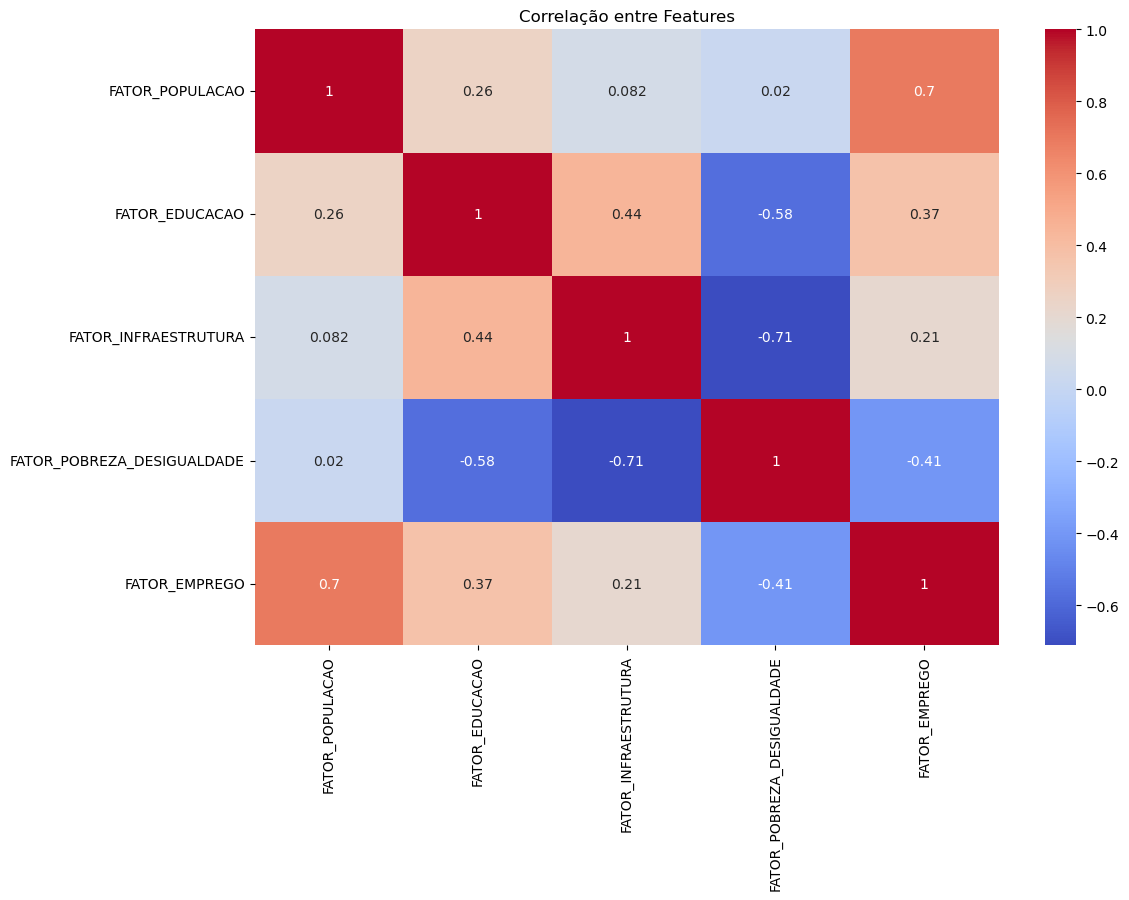

                      feature       VIF
3  FATOR_POBREZA_DESIGUALDADE  4.236614
4               FATOR_EMPREGO  3.440555
0             FATOR_POPULACAO  3.110018
2        FATOR_INFRAESTRUTURA  2.383586
1              FATOR_EDUCACAO  1.705385


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre Features')
plt.show()

# VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

<strong><h2>MACHINE LEARNING</h2></strong>

Esta seção é dedicada à criação do modelo preditivo capaz de performar bem e retornar os fatores mais importantes para a explicação da violência letal.


In [14]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map
from tqdm_joblib import tqdm_joblib
from scipy.stats import randint, uniform
import warnings

<strong><h3>Treinando um modelo de Random Forest</h3></strong>


🔁 Total estimado de avaliações: 2100


🔄 Avaliação Geral:   0%|          | 0/2100 [00:00<?, ?it/s]


📏 Tamanho de treino: 94%


2391it [01:23, 28.52it/s] 
🔄 Avaliação Geral:   0%|          | 0/2100 [01:23<?, ?it/s]
C:\Users\Beerserker\AppData\Local\Temp\ipykernel_39172\730131300.py:119: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Beerserker\anaconda3\envs\dev-py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


✅ R² Treino: 0.555 | R² Teste: 0.421 | R² CV: 0.266
🏆 Melhores Hiperparâmetros: {'bootstrap': True, 'ccp_alpha': 0.43357853570714144, 'max_depth': 30, 'max_features': 0.4137163005177734, 'min_samples_leaf': 2, 'min_samples_split': 19, 'n_estimators': 291}


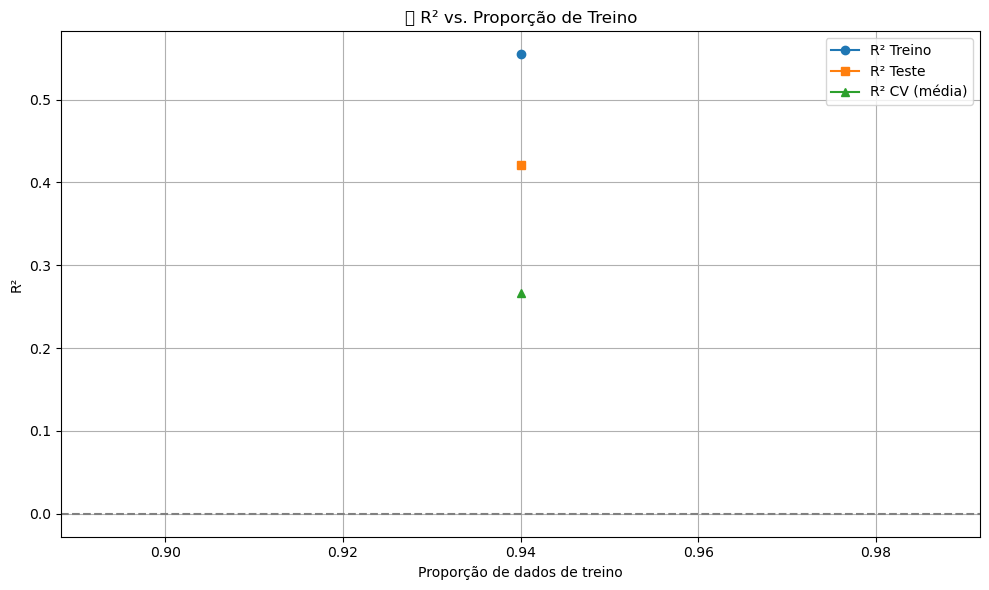

In [19]:
def avaliar_random_forest_em_varios_tamanhos(
    X, y,
    train_sizes=np.arange(0.1, 0.91, 0.05),
    search_type='grid',
    param_grid=None,
    cv_splits=5,
    n_iter_random=10,
    random_state=42,
    verbose=1,
    melhor_apenas=True
):
    """
    Avalia Random Forest com busca de hiperparâmetros em diferentes tamanhos de treino.

    Retorno:
        - Se melhor_apenas=True: retorna apenas o melhor modelo (estilo GridSearchCV).
        - Se melhor_apenas=False: retorna histórico completo.
    """
    r2_treino_lista = []
    r2_teste_lista = []
    r2_cv_lista = []
    tamanhos_treino = []
    best_estimators = []
    best_params = []

    melhores_detalhes = {'r2_teste': -np.inf}

    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 150, 200],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [0.2, 0.4, 0.6],
            'ccp_alpha': [0.0, 0.01, 0.02],
            'bootstrap': [True, False]
        }

    total_tamanhos = len(train_sizes)

    # Estimando total de avaliações para progress bar
    if search_type == 'grid':
        total_avaliacoes = np.prod([len(v) for v in param_grid.values()]) * cv_splits * total_tamanhos
    elif search_type == 'random':
        total_avaliacoes = n_iter_random * cv_splits * total_tamanhos
    else:
        raise ValueError("search_type deve ser 'grid' ou 'random'.")

    print(f"🔁 Total estimado de avaliações: {total_avaliacoes}")

    with tqdm(total=total_avaliacoes, desc="🔄 Avaliação Geral") as progress_bar:
        for size in train_sizes:
            if verbose:
                print(f"\n📏 Tamanho de treino: {int(size * 100)}%")

            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=random_state)
            base_model = RandomForestRegressor(random_state=random_state, n_jobs=-1)
            kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

            if search_type == 'grid':
                search = GridSearchCV(base_model, param_grid, cv=kf, scoring='r2', n_jobs=-1, verbose=0)
                n_iter = np.prod([len(v) for v in param_grid.values()]) * cv_splits
            else:
                search = RandomizedSearchCV(
                    base_model, param_distributions=param_grid, n_iter=n_iter_random,
                    cv=kf, scoring='r2', n_jobs=-1, random_state=random_state, verbose=0
                )
                n_iter = n_iter_random * cv_splits

            # Avança a barra de progresso global
            with tqdm_joblib(progress_bar, total=n_iter):
                search.fit(X_train, y_train)

            melhor_modelo = search.best_estimator_
            y_pred_train = melhor_modelo.predict(X_train)
            y_pred_test = melhor_modelo.predict(X_test)

            r2_train = r2_score(y_train, y_pred_train)
            r2_test = r2_score(y_test, y_pred_test)
            r2_cv_mean = search.best_score_

            r2_treino_lista.append(r2_train)
            r2_teste_lista.append(r2_test)
            r2_cv_lista.append(r2_cv_mean)
            tamanhos_treino.append(size)
            best_estimators.append(melhor_modelo)
            best_params.append(search.best_params_)

            if verbose:
                print(f"✅ R² Treino: {r2_train:.3f} | R² Teste: {r2_test:.3f} | R² CV: {r2_cv_mean:.3f}")
                print(f"🏆 Melhores Hiperparâmetros: {search.best_params_}")

            if r2_train > melhores_detalhes.get('r2_train', -np.inf):
                melhores_detalhes = {
                    'melhor_modelo': melhor_modelo,
                    'X_train': X_train,
                    'y_train': y_train,
                    'y_pred_train': y_pred_train,
                    'X_teste': X_test,
                    'y_teste': y_test,
                    'y_pred_teste': y_pred_test,
                    'r2_train': -np.inf,
                    'r2_teste': r2_test,
                    'r2_cv': r2_cv_mean,
                    }


    # Gráfico final
    plt.figure(figsize=(10, 6))
    plt.plot(tamanhos_treino, r2_treino_lista, label='R² Treino', marker='o')
    plt.plot(tamanhos_treino, r2_teste_lista, label='R² Teste', marker='s')
    plt.plot(tamanhos_treino, r2_cv_lista, label='R² CV (média)', marker='^')
    plt.axhline(0, color='gray', linestyle='--')
    plt.title("📊 R² vs. Proporção de Treino")
    plt.xlabel("Proporção de dados de treino")
    plt.ylabel("R²")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Saída
    if melhor_apenas:
        return melhores_detalhes
    else:
        idx_melhor = int(np.argmax(r2_treino_lista))
        X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
            X, y, train_size=tamanhos_treino[idx_melhor], random_state=random_state
        )
        return {
            'train_sizes': tamanhos_treino,
            'r2_treino': r2_treino_lista,
            'r2_teste': r2_teste_lista,
            'r2_cv': r2_cv_lista,
            'best_estimators': best_estimators,
            'best_params': best_params,
            'X_train_best': X_train_best,
            'X_test_best': X_test_best,
            'y_train_best': y_train_best,
            'y_test_best': y_test_best,
            'melhor_indice': idx_melhor
        }

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'max_features': uniform(0.1, 0.9),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'ccp_alpha': np.linspace(0.0001, 0.9, 5000),
    'bootstrap': [True]
}
resultados = avaliar_random_forest_em_varios_tamanhos(
    X, y,
    train_sizes=np.arange(0.94, 0.941, 0.01),
    search_type='random',
    param_grid=param_dist,
    n_iter_random=700,
    cv_splits=3,
    random_state=42,
)

<strong><h3>Salvando o melhor modelo encontrado</h3></strong>


In [ ]:
# import pickle

# # # Salva o melhor modelo
# with open('Melhor modelo/melhor_modelo_random_forest_R2_749_com_mais_fatores.pkl', 'wb') as f:
#     pickle.dump(resultados, f)

<strong><h3>Carregando o melhor modelo criado</h3></strong>

Decidir, na celula abaixo, se vai carregar o modelo treinado no código acima ou vai carregar o modelo já treinado que está em extensão pickle. Por padrão, carrega o modelo que já está pronto.



**ATENÇÃO!!!!!**

Se houver mensagem de erro ou warnings quando carregar o modelo pronto, significa que alguma biblioteca (provavelmente sklearn) está em uma versão diferente da que deveria estar, o que corrompe o carregamnto do modelo e afeta a sua performance. Isso tudo foi feito no ambiente python 3.12.7


In [15]:
def recuperar_modelo(carregar_modelo:bool=True):
    """Se True, carrega o melhor modelo já feito e que está salvo. De outro modo,
    utiliza o modelo que foi treinado agora.
    
    Retorna as variáveis: melhor modelo, X_train, y_train"""
    if carregar_modelo:
        import pickle

        # Carrega o modelo salvo
        with open('melhor_modelo_random_forest_R2_749_com_mais_fatores.pkl', 'rb') as f:
            modelo_carregado = pickle.load(f)

        melhor_modelo = modelo_carregado["melhor_modelo"]
        y_train = modelo_carregado["y_train"]
        X_train = modelo_carregado["X_train"]

    else:
        
        melhor_modelo = resultados["melhor_modelo"]
        y_train = resultados["y_train"]
        X_train = resultados["X_train"]
    
    return melhor_modelo, X_train, y_train

melhor_modelo, X_train, y_train = recuperar_modelo()

<strong><h3>Avaliando a performance do modelo nos dados do ano seguinte</h3></strong>


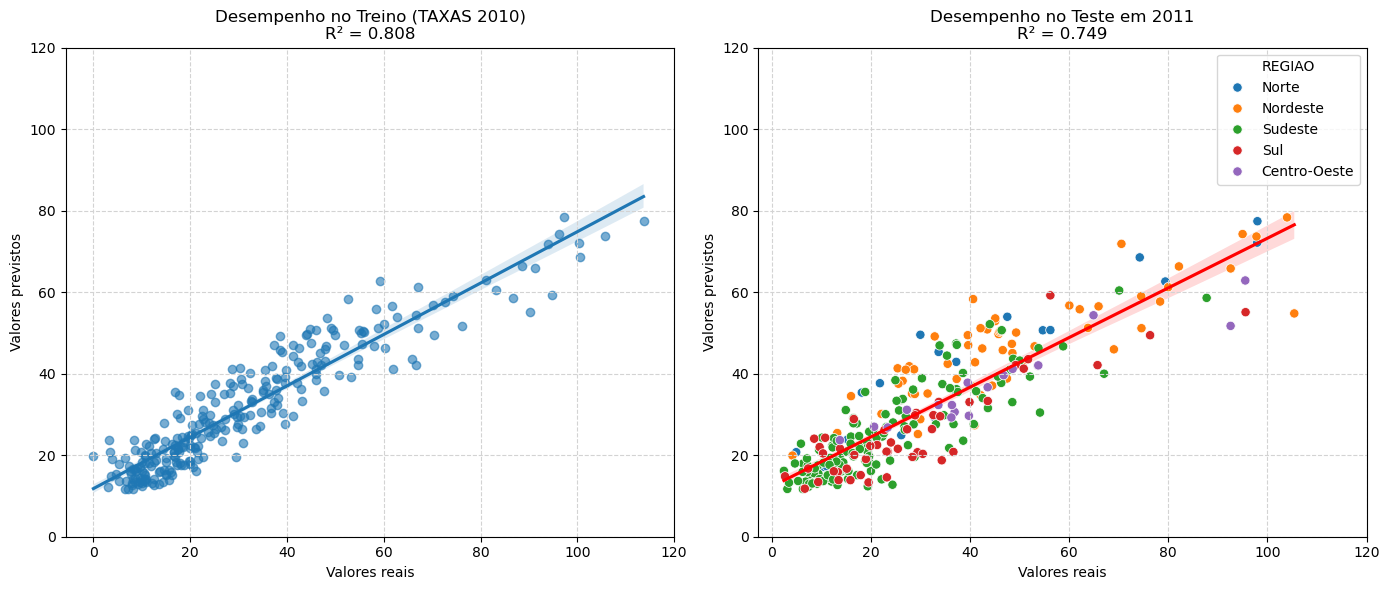

In [16]:
ano = 2011

# Criação dos subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1 - Treino
sns.regplot(
    x=y_train, 
    y=melhor_modelo.predict(X_train), 
    ax=axs[0], 
    scatter_kws={'alpha': 0.6}
)

axs[0].set_title(f'Desempenho no Treino (TAXAS 2010)\nR² = {r2_score(y_train, melhor_modelo.predict(X_train)):.3f}')
axs[0].set_xlabel('Valores reais')
axs[0].set_ylabel('Valores previstos')
axs[0].set_xticks(range(0, 130, 20))
axs[0].set_yticks(range(0, 130, 20))
axs[0].grid(True, color='lightgrey', linestyle='--')

# Subplot 2 - Teste em novo ano
sns.regplot(
    x=base_taxas_de_violencia_2010_2022_filtrada[f'TAXA_{ano}'],
    y=melhor_modelo.predict(df_PCA.iloc[:,1:]),
    ax=axs[1],
    scatter=False,
    scatter_kws={'alpha': 0.99},
    color='red',
)

sns.scatterplot(
    data=df_unificado_filtrado, 
    x=base_taxas_de_violencia_2010_2022_filtrada[f'TAXA_{ano}'], 
    y=melhor_modelo.predict(df_PCA.iloc[:,1:]), 
    hue='REGIAO',
    s=45
)

axs[1].set_title(f'Desempenho no Teste em {ano}\nR² = {r2_score(base_taxas_de_violencia_2010_2022_filtrada[f"TAXA_{ano}"], melhor_modelo.predict(df_PCA.iloc[:,1:])):.3f}')
axs[1].set_xlabel('Valores reais')
axs[1].set_ylabel('Valores previstos')
axs[1].set_xticks(range(0, 130, 20))
axs[1].set_yticks(range(0, 130, 20))
axs[1].grid(True, color='lightgrey', linestyle='--')
plt.tight_layout()
plt.show()


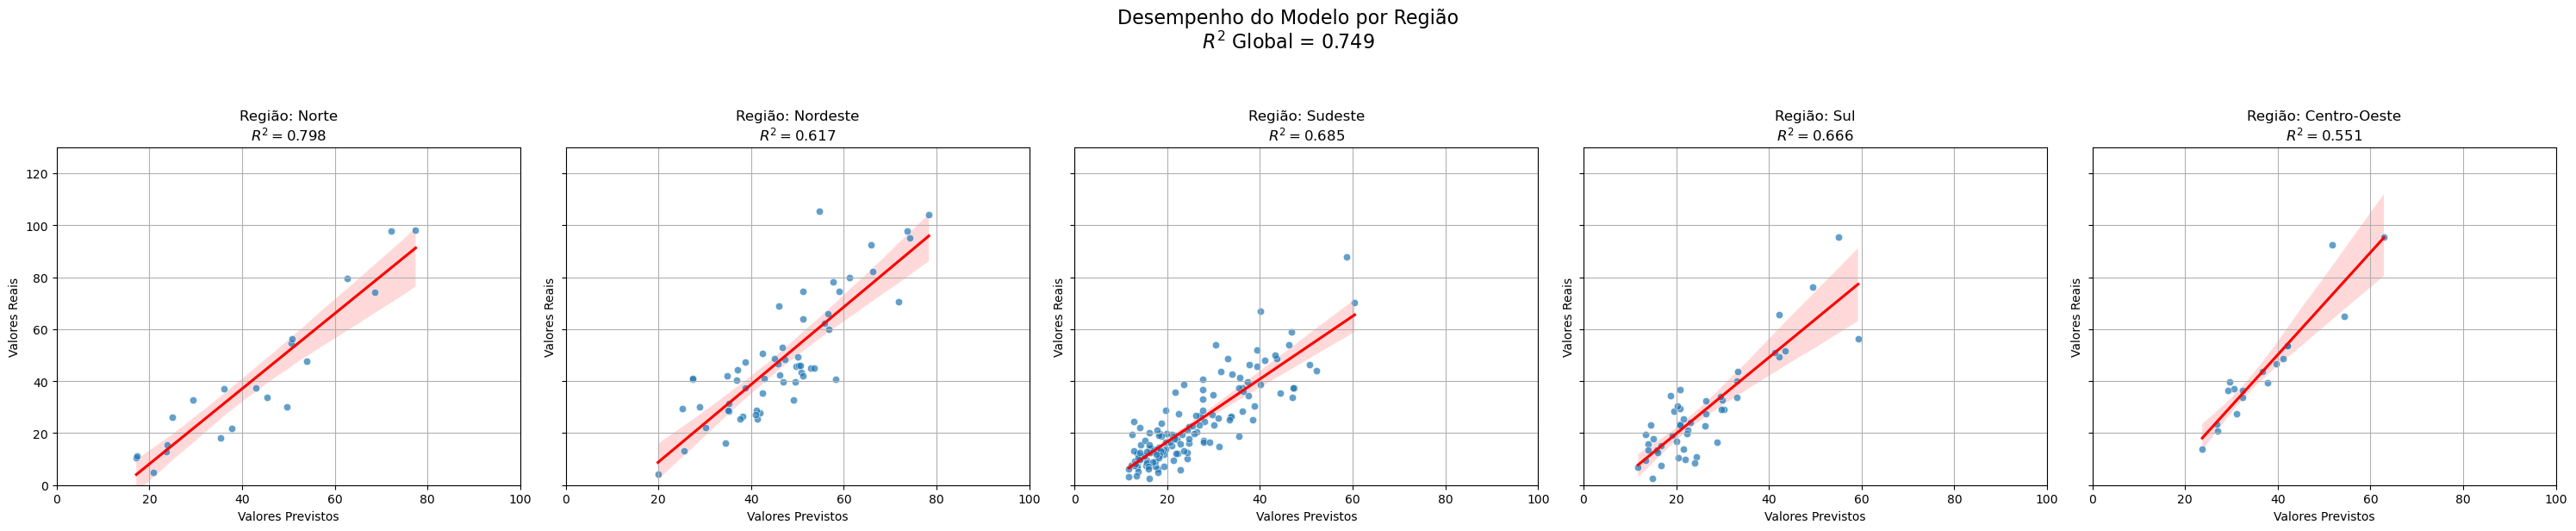

In [17]:
# Supondo que os DataFrames e o modelo já estão carregados
X = X
y = base_taxas_de_violencia_2010_2022_filtrada['TAXA_2011']

# 1. Predição é feita apenas UMA VEZ e armazenada em y_pred
y_pred = melhor_modelo.predict(X)

# Regiões únicas
regioes = df_unificado_filtrado['REGIAO'].unique()
n_regioes = len(regioes)

# Criar subplots
fig, axes = plt.subplots(nrows=1, ncols=n_regioes, figsize=(6 * n_regioes, 6), sharey=True)

# Caso só tenha uma região, `axes` não será iterável — força lista
if n_regioes == 1:
    axes = [axes]

# Plot por região
for ax, regiao in zip(axes, regioes):
    # Assumindo que a ordem das linhas é garantida, como conversamos
    mask = base_taxas_de_violencia_2010_2022_filtrada['REGIAO'] == regiao
    y_real = y[mask]
    y_previsto = y_pred[mask]
    
    # Calcula o R² apenas para a região atual
    r2_regional = r2_score(y_real, y_previsto)

    # Gráficos de dispersão e regressão
    sns.regplot(x=y_previsto, y=y_real, ax=ax, scatter=False, line_kws={'color': 'red', 'linestyle': '-'})
    sns.scatterplot(x=y_previsto, y=y_real, ax=ax, alpha=0.7)
    
    # Adiciona o R² regional ao título do subplot
    ax.set_title(f'Região: {regiao}\n$R^2 = {r2_regional:.3f}$', fontsize=12)
    
    ax.set_xlabel('Valores Previstos')
    ax.set_ylabel('Valores Reais')
    ax.grid(True)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 130)
    ax.set_xticks(range(0, 101, 20))
    ax.set_yticks(range(0, 131, 20))

# --- PONTOS CORRIGIDOS ---

# 2. CORRIGIDO E OTIMIZADO: Reutiliza y_pred (evita predição duplicada) e remove o .__round__(3)
r2_global = r2_score(y, y_pred)

# 3. CORRIGIDO: O valor de r2_global já é formatado diretamente na f-string abaixo.
#    O título do gráfico foi ajustado para usar R² com o 2 sobrescrito corretamente.
fig.suptitle(f'Desempenho do Modelo por Região\n$R^2$ Global = {r2_global:.3f}', fontsize=16, y=1.02)

# 4. CORRIGIDO: Ajustado o 'rect' para evitar que o super-título se sobreponha aos títulos dos subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

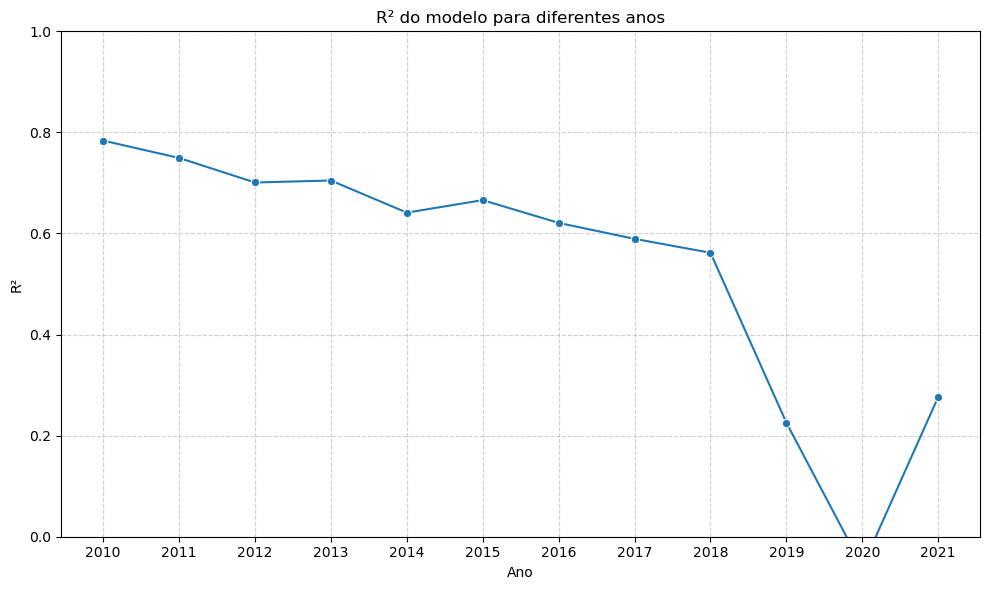

In [18]:
# Dicionário para armazenar os resultados
r2_por_ano = {}

# Itera sobre os anos e calcula o R² para cada ano
for col in base_taxas_de_violencia_2010_2022_filtrada.loc[:, 'TAXA_2010':'TAXA_2021']:
    r2 = r2_score(base_taxas_de_violencia_2010_2022_filtrada[col], melhor_modelo.predict(X))
    r2_por_ano[col] = r2

# Converte para Series e ajusta o índice para mostrar apenas o ano
r2_series = pd.Series(r2_por_ano)
r2_series.index = r2_series.index.str.extract(r'TAXA_(\d+)', expand=False).astype(int)

# Plotagem
plt.figure(figsize=(10, 6))
sns.lineplot(x=r2_series.index, y=r2_series.values, marker='o')
plt.title('R² do modelo para diferentes anos')
plt.xlabel('Ano')
plt.ylabel('R²')
plt.xticks(range(2010, 2022, 1))
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

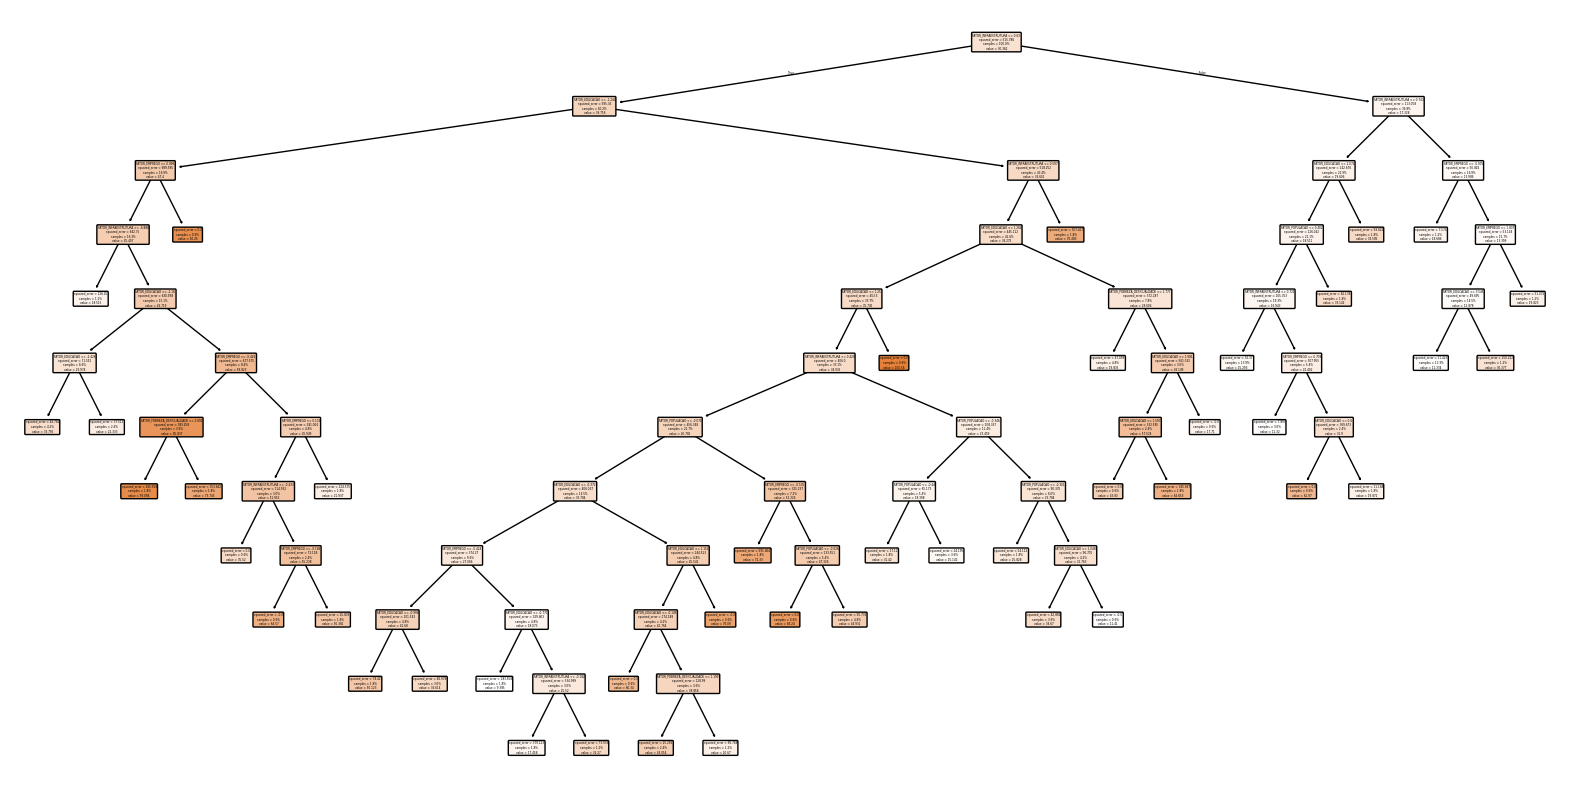

In [19]:
plt.figure(figsize=(20, 10))
plot_tree(melhor_modelo.estimators_[0], 
          filled=True, 
          feature_names=X.columns,
          rounded=True, 
          proportion=True,
          )
plt.show()

<strong><h3>Avaliando os fatores com maior peso<h3></strong>


C:\Users\Beerserker\AppData\Local\Temp\ipykernel_30240\1152243111.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


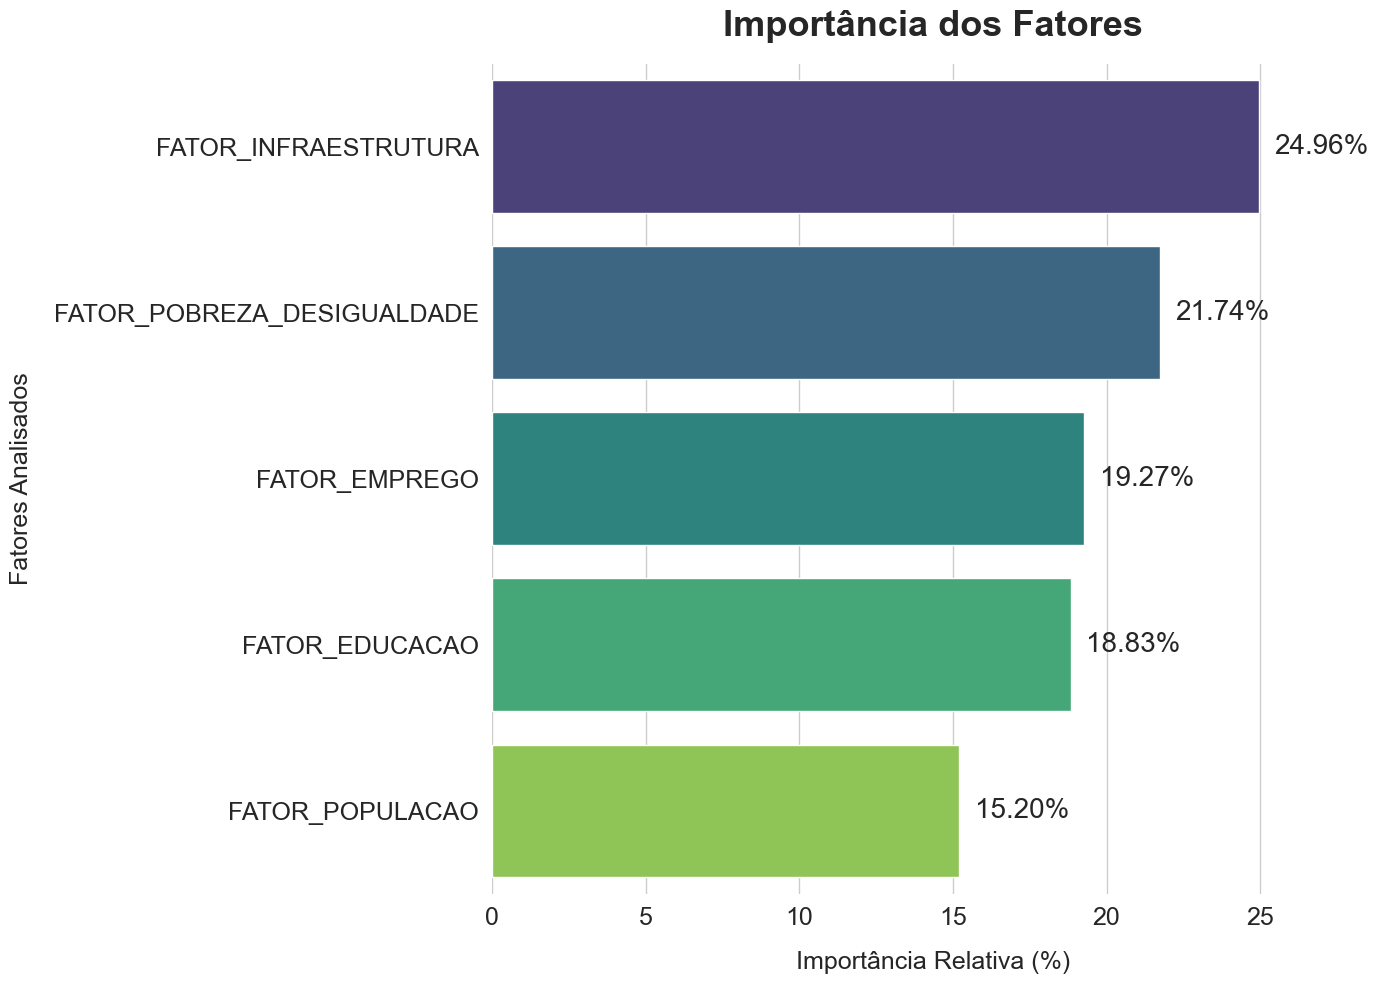

In [20]:
importancia_das_variaveis = pd.DataFrame({
    "FATORES": X.columns,
    "IMPORTÂNCIA": melhor_modelo.feature_importances_
}).sort_values(by='IMPORTÂNCIA', ascending=False)

# --- Preparação para o Gráfico ---
# Converte a importância para um formato percentual para exibição no gráfico
# Note o uso da coluna 'IMPORTÂNCIA' com acento, conforme o seu DataFrame
importancia_das_variaveis['IMPORTANCIA_PERC'] = importancia_das_variaveis['IMPORTÂNCIA'] * 100

# --- Geração do Gráfico ---
# Define um estilo visualmente agradável para o gráfico
sns.set_theme(style="whitegrid")

# Cria a figura e os eixos do gráfico, definindo um bom tamanho
plt.figure(figsize=(14, 10))

# Cria o gráfico de barras horizontais com uma paleta de cores
# A paleta 'viridis' oferece uma boa variação de cores
barplot = sns.barplot(
    x='IMPORTANCIA_PERC',
    y='FATORES',
    data=importancia_das_variaveis,
    palette='viridis'
)

# Adiciona os rótulos de percentual ao lado de cada barra
for p in barplot.patches:
    width = p.get_width() # Pega a largura da barra (o valor da importância)
    plt.text(
        width + 0.5,      # Posição X do texto (um pouco à direita da barra)
        p.get_y() + p.get_height() / 2, # Posição Y do texto (centralizado na altura da barra)
        f'{width:.2f}%',  # O texto a ser exibido, formatado com 2 casas decimais
        ha='left',      # Alinhamento horizontal do texto
        va='center',    # Alinhamento vertical do texto
        fontsize=20       # Tamanho da fonte do rótulo
    )

# --- Customização e Títulos ---
# Adiciona um título claro e informativo ao gráfico
plt.title('Importância dos Fatores', fontsize=26, pad=20, weight='bold')

# Renomeia os eixos para maior clareza
plt.xlabel('Importância Relativa (%)', fontsize=18, labelpad=15)
plt.ylabel('Fatores Analisados', fontsize=18, labelpad=15)

# Ajusta o limite do eixo X para dar espaço para os rótulos
plt.xlim(0, importancia_das_variaveis['IMPORTANCIA_PERC'].max() * 1.15)

# Melhora a legibilidade dos ticks dos eixos
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Remove as bordas desnecessárias para um visual mais limpo
sns.despine(left=True, bottom=True)

# Ajusta o layout para evitar que os elementos se sobreponham
plt.tight_layout()

# Exibe o gráfico
plt.show()


<strong><h2>K-MEANS PARA INTERPRETAR FATORES</h2></strong>

Usar uma modelode K-Means para compreender melhor os agrupamentos de municípios que se formam na relação entre os fatores e a taxa de violência

c:\Users\Beerserker\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Beerserker\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Beerserker\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Beerserker\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Beerserker\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    h

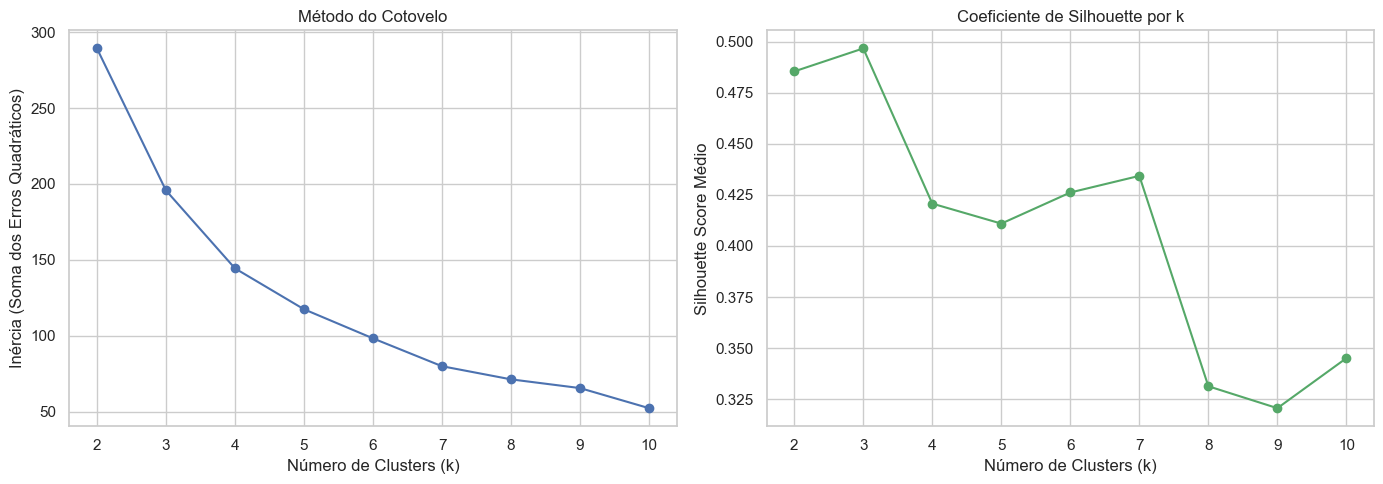

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df_PCA[['TAXA_VIOLENCIA', 'FATOR_POBREZA_DESIGUALDADE']].dropna()

# Padronização para evitar distorções por escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Testando diferentes valores de k
inertia = []
silhouettes = []
k_range = range(2, 11)  # Evita k=1, pois silhouette não é definido

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot do método do cotovelo
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma dos Erros Quadráticos)')
plt.title('Método do Cotovelo')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, 'go-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score Médio')
plt.title('Coeficiente de Silhouette por k')

plt.tight_layout()
plt.show()


Melhor k com base no silhouette score: 3


c:\Users\Beerserker\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


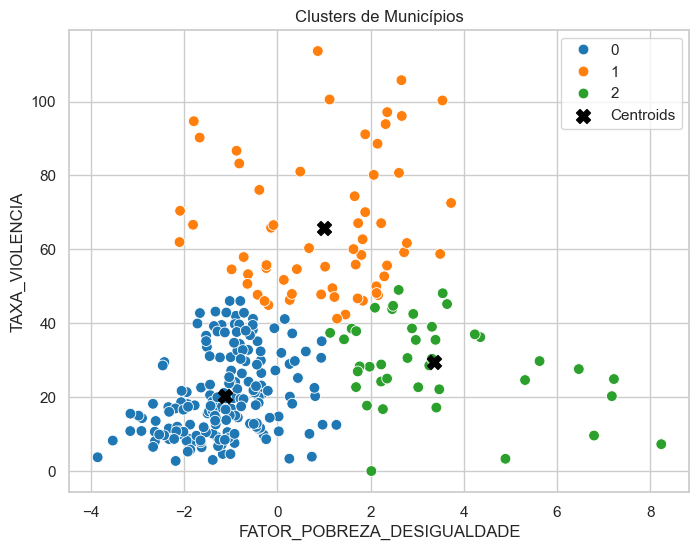

In [22]:
melhor_k = k_range[np.argmax(silhouettes)]
print(f'Melhor k com base no silhouette score: {melhor_k}')

kmeans_final = KMeans(n_clusters=melhor_k, random_state=42, n_init='auto')
X['cluster'] = kmeans_final.fit_predict(X_scaled)

# Visualização em 2D dos clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='FATOR_POBREZA_DESIGUALDADE', 
    y='TAXA_VIOLENCIA', 
    hue='cluster', 
    data=X, 
    palette='tab10', 
    s=60
)
centroids = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(
    centroids[:, 1], centroids[:, 0], 
    c='black', s=100, marker='X', label='Centroids'
)
plt.title('Clusters de Municípios')
plt.legend()
plt.grid(True)
plt.show()


<strong><h2>TESTANDO UM MODELO PARAMÉTRICO</h2></strong>

Esta seção é dedicada à criação do modelo preditivo capaz de performar bem e retornar os fatores mais importantes para a explicação da violência letal. 

Até agora nenhum modelo paramétrico chegou perto do Random Forest.

 No fim, eles servem mais pra mostrar que o modelo criado é melhor do que modelos tradicionais de regressão, provavelmente por não ser paramétrico, ou seja, não ter fortes pressuspostos nos dados e estar relativamente "overfittado" aos dados de 2010.

In [28]:
import statsmodels.api as sm
from statstests.tests import shapiro_francia

# Cópia do DataFrame e transformação logarítmica
df_PCA_parametrico = df_PCA.copy()
df_PCA_parametrico['TAXA_VIOLENCIA'] = np.log1p(df_PCA_parametrico['TAXA_VIOLENCIA'])

# Modelo OLS com fórmula
lm = sm.OLS.from_formula(
    "TAXA_VIOLENCIA ~ FATOR_POPULACAO + FATOR_EDUCACAO + FATOR_INFRAESTRUTURA + \
     FATOR_POBREZA_DESIGUALDADE + FATOR_EMPREGO",
    data=df_PCA_parametrico
).fit()

# Teste de normalidade dos resíduos
shapiro_francia(lm.resid)


# Resumo do modelo
print(lm.summary())


method  :  Shapiro-Francia normality test
statistics W  :  0.9708575775662998
statistics z  :  3.9165544484459067
p-value  :  4.491176800614491e-05
                            OLS Regression Results                            
Dep. Variable:         TAXA_VIOLENCIA   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     17.90
Date:                sex, 20 jun 2025   Prob (F-statistic):           2.28e-15
Time:                        15:03:47   Log-Likelihood:                -276.75
No. Observations:                 282   AIC:                             565.5
Df Residuals:                     276   BIC:                             587.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t   

Lambda ótimo estimado pelo Box-Cox: 0.2138
method  :  Shapiro-Francia normality test
statistics W  :  0.9858963291912489
statistics z  :  2.382089961634074
p-value  :  0.00860734570335515
                              OLS Regression Results                             
Dep. Variable:     TAXA_VIOLENCIA_BOXCOX   R-squared:                       0.254
Model:                               OLS   Adj. R-squared:                  0.241
Method:                    Least Squares   F-statistic:                     18.83
Date:                   sex, 20 jun 2025   Prob (F-statistic):           4.21e-16
Time:                           15:03:47   Log-Likelihood:                -465.00
No. Observations:                    282   AIC:                             942.0
Df Residuals:                        276   BIC:                             963.9
Df Model:                              5                                         
Covariance Type:               nonrobust                                  

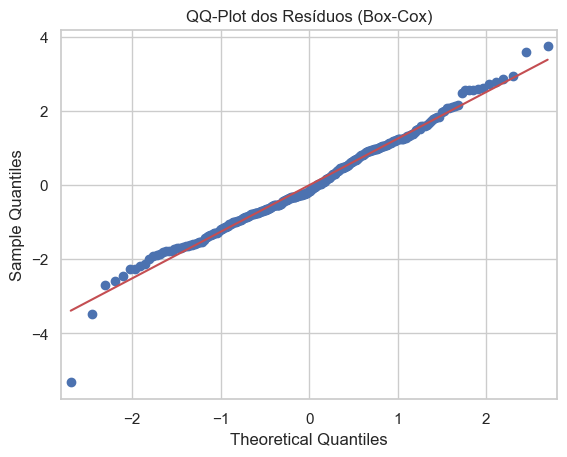

In [29]:
from scipy.stats import boxcox

# Cópia do DataFrame
df_PCA_boxcox = df_PCA.copy()

# Box-Cox exige y > 0
y_original = df_PCA_boxcox['TAXA_VIOLENCIA'].copy() +1 

# Aplicar transformação de Box-Cox
y_transf, fitted_lambda = boxcox(y_original)

# Armazenar transformação no DataFrame
df_PCA_boxcox['TAXA_VIOLENCIA_BOXCOX'] = y_transf

print(f"Lambda ótimo estimado pelo Box-Cox: {fitted_lambda:.4f}")

# Modelo com a variável transformada
modelo_bc = sm.OLS.from_formula(
    "TAXA_VIOLENCIA_BOXCOX ~ FATOR_POPULACAO + FATOR_EDUCACAO + FATOR_INFRAESTRUTURA + \
     FATOR_POBREZA_DESIGUALDADE + FATOR_EMPREGO",
    data=df_PCA_boxcox
).fit()

# Teste de normalidade dos resíduos (Shapiro-Francia)
shapiro_francia(modelo_bc.resid)

# Resumo do modelo
print(modelo_bc.summary())

# QQ-Plot para diagnóstico visual dos resíduos
sm.qqplot(modelo_bc.resid, line='s')
plt.title("QQ-Plot dos Resíduos (Box-Cox)")
plt.show()


method  :  Shapiro-Francia normality test
statistics W  :  0.9425837821897894
statistics z  :  5.350319788444501
p-value  :  4.38994725546075e-08
{'method': 'Shapiro-Francia normality test', 'statistics W': 0.9425837821897894, 'statistics z': 5.350319788444501, 'p-value': 4.38994725546075e-08}
                 Generalized Linear Model Regression Results                  
Dep. Variable:     TAXA_VIOLENCIA_adj   No. Observations:                  282
Model:                            GLM   Df Residuals:                      276
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                        0.036527
Method:                          IRLS   Log-Likelihood:                -278.74
Date:                sex, 20 jun 2025   Deviance:                       11.472
Time:                        15:03:53   Pearson chi2:                     10.1
No. Iterations:                    11   Pseudo R-squ. (CS):             0

c:\Users\Beerserker\anaconda3\Lib\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


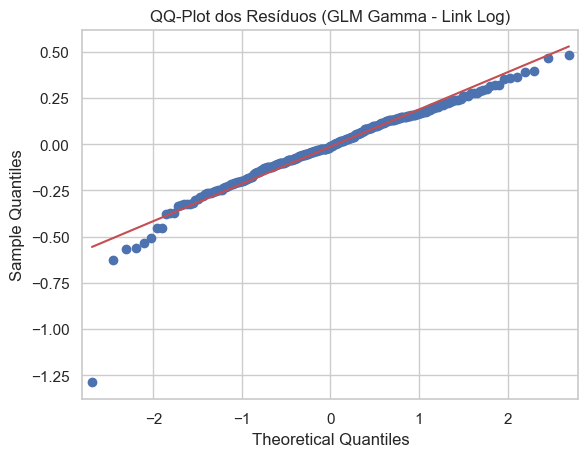

In [31]:
# Cópia do DataFrame
df_PCA_glm = df_PCA.copy()

# Ajustando a variável de resposta para garantir y > 0 (caso haja zeros)
df_PCA_glm['TAXA_VIOLENCIA_adj'] = np.log1p(df_PCA_glm['TAXA_VIOLENCIA'] +1)

# Definição da fórmula para o modelo GLM
formula_glm = ("TAXA_VIOLENCIA_adj ~ FATOR_POPULACAO + FATOR_EDUCACAO + "
               "FATOR_INFRAESTRUTURA + FATOR_POBREZA_DESIGUALDADE + FATOR_EMPREGO")

# Ajuste do modelo GLM com família Gamma e link logarítmico
modelo_glm = sm.GLM.from_formula(formula_glm,
                                 data=df_PCA_glm,
                                 family=sm.families.Gamma(link=sm.families.links.log())).fit()

# Teste de normalidade dos resíduos (baseado nos resíduos de deviance)
print(shapiro_francia(modelo_glm.resid_deviance))

# Resumo do modelo
print(modelo_glm.summary())

# QQ-Plot para avaliação visual dos resíduos (resíduos de deviance)
sm.qqplot(modelo_glm.resid_deviance, line='s')
plt.title("QQ-Plot dos Resíduos (GLM Gamma - Link Log)")
plt.show()

<Axes: xlabel='TAXA_VIOLENCIA_adj'>

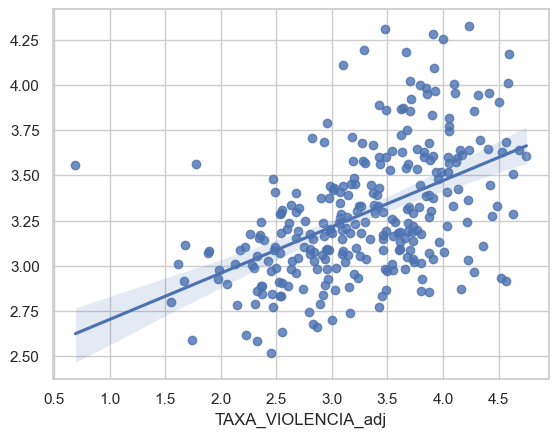

In [32]:
sns.regplot(x=df_PCA_glm['TAXA_VIOLENCIA_adj'], y=modelo_glm.predict(df_PCA_glm[['FATOR_POPULACAO', 'FATOR_EDUCACAO',
       'FATOR_INFRAESTRUTURA', 'FATOR_POBREZA_DESIGUALDADE', 'FATOR_EMPREGO']]))